In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import joblib
import os
import time

from time import time
from statsmodels.tsa.stattools import kpss
from plotnine import *

# Load the datasets
missing_tooth = pd.read_csv('missing_tooth.csv')
tooth_chipped = pd.read_csv('tooth_chipped_fault.csv')
surface_fault = pd.read_csv('surface_fault.csv')
no_fault = pd.read_csv('no_fault.csv')
root_crack = pd.read_csv('root_crack.csv')
eccentricity = pd.read_csv('eccentricity.csv')

In [2]:
missing_tooth['state'] = 'missing_tooth'
tooth_chipped['state'] = 'tooth_chipped'
surface_fault['state'] = 'surface_fault'
no_fault['state'] = 'no_fault'
root_crack['state'] = 'root_crack'
eccentricity['state'] = 'eccentricity'

df = pd.concat([
    missing_tooth, 
    tooth_chipped,
    surface_fault,
    no_fault,
    root_crack, 
    eccentricity
])
display(df.info())
#Normalize time_x grouped by state, load_value, speedSet
df['time_x'] = pd.to_datetime(df['time_x'])
df['time_normalized'] = df.groupby(['state', 'load_value', 'speedSet'])['time_x'].transform(lambda x: (x - x.min()).dt.total_seconds())

df['time_normalized']


<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          900000 non-null  float64
 1   sensor2          900000 non-null  float64
 2   time_x           900000 non-null  object 
 3   speedSet         900000 non-null  float64
 4   load_value       900000 non-null  int64  
 5   gear_fault_desc  900000 non-null  object 
 6   state            900000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 54.9+ MB


None

0         0.0000
1         0.0002
2         0.0004
3         0.0006
4         0.0008
           ...  
149995    4.9990
149996    4.9992
149997    4.9994
149998    4.9996
149999    4.9998
Name: time_normalized, Length: 900000, dtype: float64

In [3]:
df.drop(columns='time_normalized').describe()

,sensor1,sensor2,time_x,speedSet,load_value
count,900000.000000,900000.000000,900000,900000.000000,900000.000000
mean,2.519877,2.429291,2023-05-03 13:39:41.138789376,24.444010,40.000000
min,2.219428,2.161939,2023-05-02 10:30:01,8.332031,0.000000
25%,2.516895,2.426390,2023-05-02 16:02:08.249949952,8.332031,0.000000
50%,2.520180,2.429839,2023-05-03 13:54:29.499899904,25.000000,40.000000
75%,2.522972,2.432303,2023-05-03 20:28:31.249850112,40.000000,80.000000
max,2.820934,2.709896,2023-05-07 17:11:48.999800,40.000000,80.000000
std,0.011236,0.012001,NaN,12.934378,40.000022


In [4]:
df['time_formatted'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [5]:
df['sensor1_max_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().max())
df['sensor1_min_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().min())

df['sensor2_max_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().max())
df['sensor2_min_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().min())

df['sensor1_mean_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
df['sensor2_mean_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())

df['sensor1_std_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().std())
df['sensor2_std_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().std())


In [6]:
# Define the variables before using them
speedload_8_0 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 0)].copy()
speedload_8_80 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 80)].copy()
speedload_25_0 = df[(df['speedSet'] == 25) & (df['load_value'] == 0)].copy()
speedload_25_80 = df[(df['speedSet'] == 25) & (df['load_value'] == 80)].copy()
speedload_40_0 = df[(df['speedSet'] == 40) & (df['load_value'] == 0)].copy()
speedload_40_80 = df[(df['speedSet'] == 40) & (df['load_value'] == 80)].copy()

# Calculate the avarage column for sensor1 and sensor2 values in time for speedLoad 8.33 and 0 and then the other combinations
speedload_8_0['sensor1_avg'] = speedload_8_0.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_8_0['sensor2_avg'] = speedload_8_0.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_8_80['sensor1_avg'] = speedload_8_80.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_8_80['sensor2_avg'] = speedload_8_80.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_25_0['sensor1_avg'] = speedload_25_0.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_25_0['sensor2_avg'] = speedload_25_0.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_25_80['sensor1_avg'] = speedload_25_80.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_25_80['sensor2_avg'] = speedload_25_80.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_40_0['sensor1_avg'] = speedload_40_0.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_40_0['sensor2_avg'] = speedload_40_0.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_40_80['sensor1_avg'] = speedload_40_80.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_40_80['sensor2_avg'] = speedload_40_80.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())


In [7]:
# Apply the KPSS test to each unique state for 'sensor1' values by 'normalized_time'.
def apply_kpss(series):
    kpss_stat, p_value, lags, crit = kpss(series, 'c')
    return kpss_stat, p_value, crit

# Apply the KPSS test to all unique states
unique_states = speedload_8_0['state'].unique()
kpss_results = {}
for state in unique_states:
    # Extracting the time series data for 'sensor1' for the current state
    time_series = speedload_8_0.loc[speedload_8_0['state'] == state, 'sensor1']
    # Applying KPSS test
    kpss_stat, p_value, crit = apply_kpss(time_series)
    kpss_results[state] = (kpss_stat, p_value, crit)

# You can print out the results or convert it to a DataFrame
kpss_results_df = pd.DataFrame(kpss_results, index=['KPSS Statistic', 'p-value', 'Critical Values']).T
print(kpss_results_df)

              KPSS Statistic   p-value  \
missing_tooth       0.098826       0.1   
tooth_chipped       3.135916      0.01   
surface_fault       0.374733  0.088046   
no_fault            2.016985      0.01   
root_crack          9.098141      0.01   
eccentricity        1.742396      0.01   

                                                 Critical Values  
missing_tooth  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
tooth_chipped  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
surface_fault  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
no_fault       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
root_crack     {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
eccentricity   {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  


C:\Users\rober\AppData\Local\Temp\ipykernel_15484\3764876985.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_15484\3764876985.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_15484\3764876985.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_15484\3764876985.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_15484\3764876985.py:

In [8]:
"""
# Define your custom color palette
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']

# Plot the sensor1_avg values then sensor2_avg values in time for every speedSet and load_value combination in seperate plots for each state
display(ggplot(data = speedload_8_0, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 0'))
display(ggplot(data = speedload_8_0, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 0'))
display(ggplot(data = speedload_8_80, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_8_80, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 80'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 80'))
"""


"\n# Define your custom color palette\ncolors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']\n\n# Plot the sensor1_avg values then sensor2_avg values in time for every speedSet and load_value combination in seperate plots for each state\ndisplay(ggplot(data = speedload_8_0, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 0'))\ndisplay(ggplot(data = speedload_8_0, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 0'))\ndisplay(ggplot(data = speedload_8_80, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 80'))\ndisplay(ggplot(data = speedload_8_80, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 80'))\ndisplay(ggplot(data = speedload_25_0, mapping = aes(x = 'time_normalized', y = 'sens

In [9]:
"""
display(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() + 
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.417, 2.44))
display(ggplot(data=speedload_8_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.417, 2.44))
display(ggplot(data=speedload_25_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.4, 2.45))
display(ggplot(data=speedload_25_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.4, 2.45))
display(ggplot(data=speedload_40_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0') + xlim(2.4, 2.45))
display(ggplot(data=speedload_40_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80') + xlim(2.37, 2.55))

display(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80'))
"""

"\ndisplay(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() + \n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.417, 2.44))\ndisplay(ggplot(data=speedload_8_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.417, 2.44))\ndisplay(ggplot(data=speedload_25_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.4, 2.45))\ndisplay(ggplot(data=speedload_25_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.4, 2.45))\ndisplay(ggplot(data=speedload_40_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        sca

In [10]:
"""
display(ggplot(data = df, mapping = aes(x = 'sensor1', y = 'sensor2', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
display(ggplot(data = df, mapping = aes(x = 'sensor1_std_exp', y = 'sensor2_std_exp', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
display(ggplot(data = df, mapping = aes(x = 'sensor1_mean_exp', y = 'sensor2_mean_exp', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
"""

"\ndisplay(ggplot(data = df, mapping = aes(x = 'sensor1', y = 'sensor2', color = 'no_fault'))\n         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))\ndisplay(ggplot(data = df, mapping = aes(x = 'sensor1_std_exp', y = 'sensor2_std_exp', color = 'no_fault'))\n         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))\ndisplay(ggplot(data = df, mapping = aes(x = 'sensor1_mean_exp', y = 'sensor2_mean_exp', color = 'no_fault'))\n         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))\n"

In [11]:
# Find NaN values and replace with 0
df.fillna(0, inplace=True)
df.isna().sum()

sensor1             0
sensor2             0
time_x              0
speedSet            0
load_value          0
gear_fault_desc     0
state               0
time_normalized     0
time_formatted      0
sensor1_max_exp     0
sensor1_min_exp     0
sensor2_max_exp     0
sensor2_min_exp     0
sensor1_mean_exp    0
sensor2_mean_exp    0
sensor1_std_exp     0
sensor2_std_exp     0
dtype: int64

In [12]:
"""
# Create the graph above only with no_fault vs other states
display(ggplot(data = df[df.state.isin(['no_fault', 'missing_tooth'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'tooth_chipped'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'surface_fault'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'root_crack'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'eccentricity'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
"""

"\n# Create the graph above only with no_fault vs other states\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'missing_tooth'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'tooth_chipped'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'surface_fault'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'root_crack'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'eccentricity'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\n"

In [13]:
# Create a formated column of state as Expected: [0 1 2 3 4 5] input
display(df.state.unique())
df['state_expected'] = df.state.apply(lambda x: ['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'].index(x))
# Save the transformation keys for state_expected to later reverse the transformation
mapping_dict = df.set_index('state_expected')['state'].to_dict()
display(mapping_dict)
state_expected_keys = pd.DataFrame(list(mapping_dict.items()), columns=['state_expected', 'state'])
display(state_expected_keys)
# Create a df dataset that excludes time_x, gear_fault_desc, state, time_formatted
df_edit = df[['sensor1', 'sensor2', 'speedSet', 'load_value', 'state_expected', 'time_normalized']]
display(df.state_expected.unique())


array(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault',
       'root_crack', 'eccentricity'], dtype=object)

{0: 'missing_tooth',
 1: 'tooth_chipped',
 2: 'surface_fault',
 3: 'no_fault',
 4: 'root_crack',
 5: 'eccentricity'}

,state_expected,state
0,0,missing_tooth
1,1,tooth_chipped
2,2,surface_fault
3,3,no_fault
4,4,root_crack
5,5,eccentricity


array([0, 1, 2, 3, 4, 5], dtype=int64)

In [14]:
df_edit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          900000 non-null  float64
 1   sensor2          900000 non-null  float64
 2   speedSet         900000 non-null  float64
 3   load_value       900000 non-null  int64  
 4   state_expected   900000 non-null  int64  
 5   time_normalized  900000 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 48.1 MB


In [15]:
import sqlite3
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

total_size = len(df_edit)
chunk_size = int(total_size * 0.0001)  # 0.001% of data
num_chunks_train = int(total_size * 0.8 / chunk_size)
num_chunks_val = int(total_size * 0.1 / chunk_size)
num_chunks_test = int(total_size * 0.1 / chunk_size)

# Shuffle the DataFrame
df_shuffled = df_edit.sample(frac=1, random_state=42).reset_index(drop=True)

# Function to stratify and split the data into chunks
def stratified_chunk_split(dfs, num_chunks):
    # List to store chunks
    chunks = []
    
    # Get stratified samples
    for _, group_data in dfs.groupby('state_expected'):
        group_chunks = np.array_split(group_data, num_chunks)
        chunks.extend(group_chunks)
        
    # Shuffle chunks to mix classes
    np.random.shuffle(chunks)
    
    return chunks

# Stratify and split into chunks
all_chunks = stratified_chunk_split(df_shuffled, num_chunks_train + num_chunks_val + num_chunks_test)

# Separate chunks into train, validation, and test sets
train_chunks = all_chunks[:num_chunks_train]
val_chunks = all_chunks[num_chunks_train:num_chunks_train + num_chunks_val]
test_chunks = all_chunks[num_chunks_train + num_chunks_val:]

# Combine chunks back into DataFrames
X_train = pd.concat(train_chunks, ignore_index=True)
X_test = pd.concat(val_chunks, ignore_index=True)
X_val = pd.concat(test_chunks, ignore_index=True)

y_train = X_train['state_expected']
y_test = X_test['state_expected']
y_val = X_val['state_expected']

X_train['sensor1_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).max())
X_train['sensor1_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).min())
X_train['sensor1_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).mean())
X_train['sensor1_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).std())

X_train['sensor2_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).max())
X_train['sensor2_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).min())
X_train['sensor2_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).mean())
X_train['sensor2_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).std())

X_test['sensor1_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).max())
X_test['sensor1_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).min())
X_test['sensor1_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).mean())
X_test['sensor1_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).std())

X_test['sensor2_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).max())
X_test['sensor2_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).min())
X_test['sensor2_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).mean())
X_test['sensor2_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).std())

X_val['sensor1_max'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).max())
X_val['sensor1_min'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).min())
X_val['sensor1_mean'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).mean())
X_val['sensor1_std'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=500, min_periods=1).std())

X_val['sensor2_max'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).max())
X_val['sensor2_min'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).min())
X_val['sensor2_mean'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).mean())
X_val['sensor2_std'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=500, min_periods=1).std())


# Drop column state_expected
X_train.drop(columns='state_expected', inplace=True)
X_test.drop(columns='state_expected', inplace=True)
X_val.drop(columns='state_expected', inplace=True)

# Replace NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)
print(y_val.value_counts())

# keep not standardized data in X_train_not_scaled, X_test_not_scaled, X_val_not_scaled
X_train_not_scaled = X_train.copy()
X_test_not_scaled = X_test.copy()
X_val_not_scaled = X_val.copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
start_time1 = time()
y_pred = log_reg.predict(X_test)
training_time = time() - start_time1

accuracy_lr = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lr)

# Save the model to a file
model_name = f'logistic_regression_{accuracy_lr:.4f}'

# Save the model
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
os.makedirs(model_directory, exist_ok=True)
joblib.dump(log_reg, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lr}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {log_reg.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")


state_expected
5    128190
1    127710
2    127470
3    127290
4    127170
0    127170
Name: count, dtype: int64
Accuracy: 0.6197333333333334
Model and metadata saved in models


In [16]:
X_val_not_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          765000 non-null  float64
 1   sensor2          765000 non-null  float64
 2   speedSet         765000 non-null  float64
 3   load_value       765000 non-null  int64  
 4   time_normalized  765000 non-null  float64
 5   sensor1_max      765000 non-null  float64
 6   sensor1_min      765000 non-null  float64
 7   sensor1_mean     765000 non-null  float64
 8   sensor1_std      765000 non-null  float64
 9   sensor2_max      765000 non-null  float64
 10  sensor2_min      765000 non-null  float64
 11  sensor2_mean     765000 non-null  float64
 12  sensor2_std      765000 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 75.9 MB


In [17]:
X_train

array([[ 3.95885894e-01,  1.42947134e-01, -1.24347807e+00, ...,
         7.96529926e-01,  8.77931558e-01, -9.00670654e-01],
       [ 7.28260579e-02, -1.88182864e-01,  1.20174471e+00, ...,
         7.07420175e-01, -1.17705429e+00, -9.00670654e-01],
       [-1.42499630e+00,  5.01671348e-01,  1.20174471e+00, ...,
         8.93065502e-01,  3.10416653e+00, -9.00670654e-01],
       ...,
       [ 1.02195132e-01, -2.70965357e-01,  1.20174471e+00, ...,
         3.54694194e-01,  1.37592356e+00, -1.30579455e-01],
       [-5.96626607e-04,  4.97629660e-03, -1.24347807e+00, ...,
         6.22023342e-01,  6.42293187e-01, -7.24855806e-01],
       [-5.43924428e-01,  6.12048039e-01,  1.20174471e+00, ...,
         3.54694194e-01,  1.37318358e+00, -1.31114225e-01]])

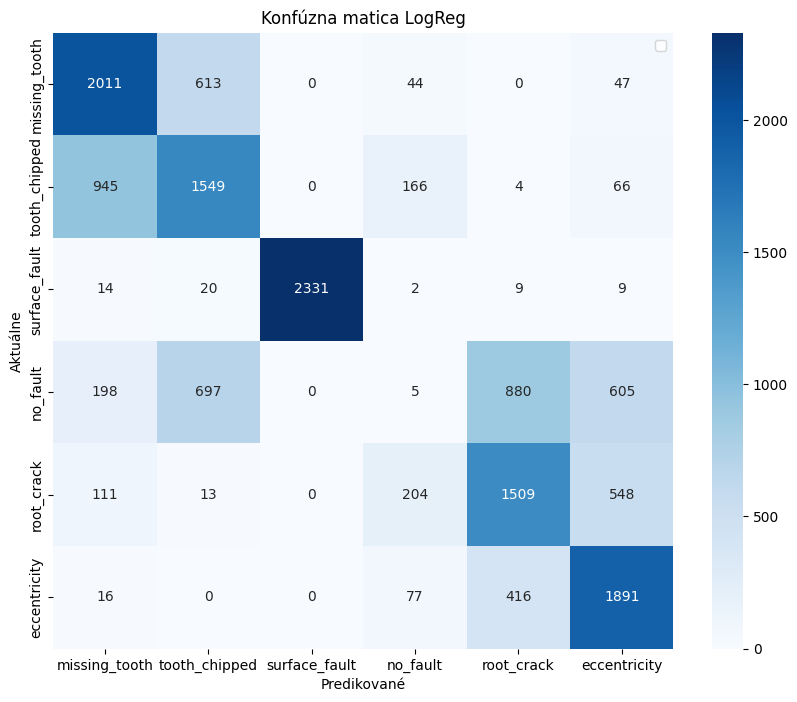

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
log_reg.classes_ = state_expected_keys.state.values
log_reg.classes_

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title('Konfúzna matica LogReg')
plt.legend([f'Presnosť: {accuracy_lr:.2f}'])
plt.show()

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# Parameter grid for RandomizedSearch
param_dist_lgb = {
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50, 100],
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1e-1, 1, 2],
    'reg_lambda': [0, 1e-1, 1, 2],
}

# Setup the model
lgb_model = lgb.LGBMClassifier()
random_search_lgb = RandomizedSearchCV(lgb_model, param_distributions=param_dist_lgb, 
    n_iter=1,  
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_lgb.fit(X_train, y_train)

# Pick the best model
best_lgb_model = random_search_lgb.best_estimator_
best_lgb_model.fit(X_train, y_train)

start_time2 = time()
# Predict the test set
y_pred = best_lgb_model.predict(X_test)
training_time = time() - start_time2

# Calculate the accuracy
accuracy_lgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_lgb))

# For LightGBM example
val_pred_lgb = best_lgb_model.predict(X_val)
val_accuracy_lgb = accuracy_score(y_val, val_pred_lgb)

# Print the validation accuracy
print(f'Validation Accuracy for LightGBM: {val_accuracy_lgb}')

# Save the model to a file
model_name = f'lightgbm_{accuracy_lgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_lgb_model, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lgb}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_lgb_model.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2758
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 13
[LightGBM] [Info] Start training from score -1.786026
[LightGBM] [Info] Start training from score -1.814005
[LightGBM] [Info] Start training from score -1.784536
[LightGBM] [Info] Start training from score -1.775640
[LightGBM] [Info] Start training from score -1.769753
[LightGBM] [Info] Start training from score -1.821703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

None

Validation Accuracy for LightGBM: 0.9624235294117647
Model and metadata saved in models


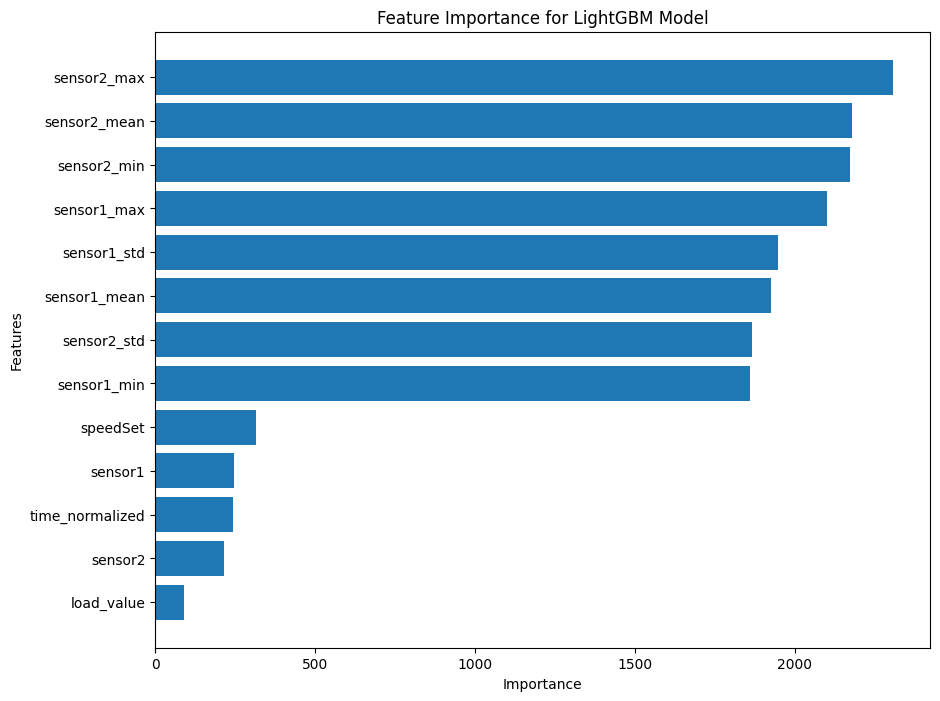

In [20]:
# Feature importance
feature_imp = best_lgb_model.feature_importances_

# Creating a DataFrame to hold the feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train_not_scaled.columns, 'Importance': feature_imp})

# Sort the DataFrame to find the most important features
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Plotting feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance for LightGBM Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
plt.show()

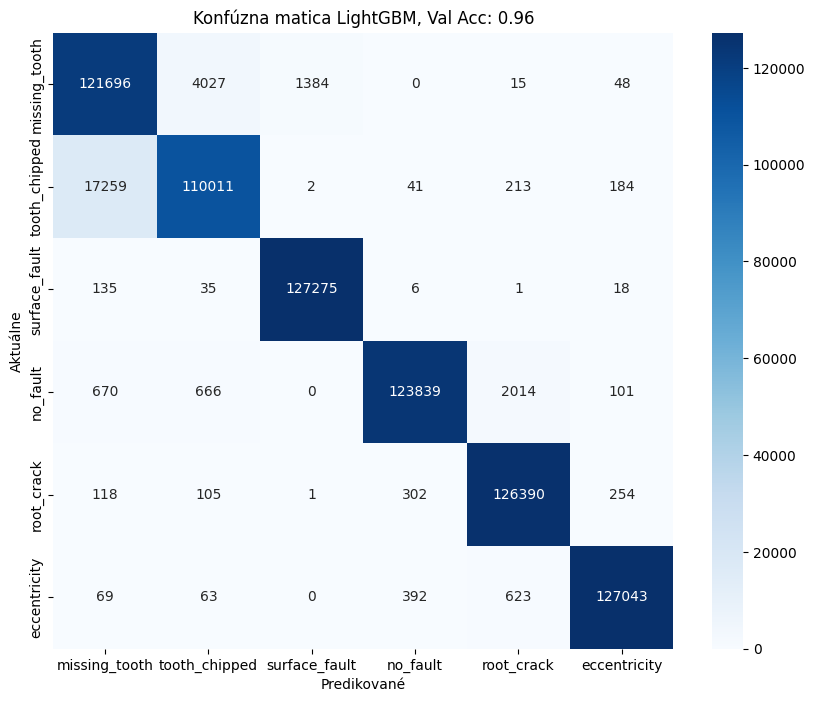

In [21]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_val, val_pred_lgb)

# Trasnform classes from numerical to names in someway
predicted_names = [mapping_dict[label] for label in best_lgb_model.classes_]
# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title(f'Konfúzna matica LightGBM, Val Acc: {val_accuracy_lgb:.2f}')
plt.show()



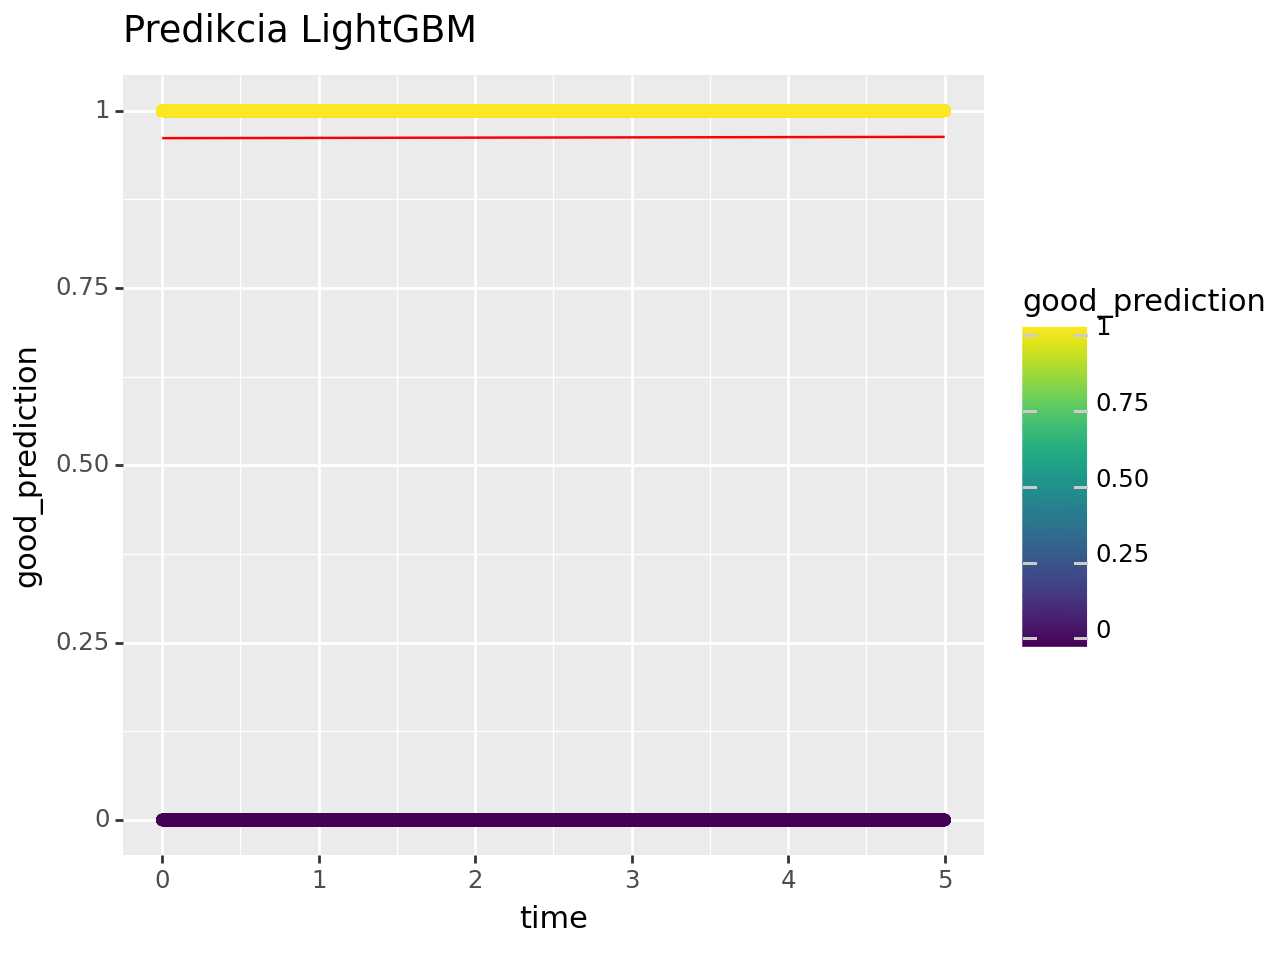

<Figure Size: (640 x 480)>

In [22]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_lgb
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia LightGBM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [23]:
# Create XGB Classifier
param_dist_xgb = {
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.01, 0.1, 1],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
}

# Setup the model
xgb_model = xgb.XGBClassifier()
random_search_xgb = RandomizedSearchCV(lgb_model, param_distributions=param_dist_xgb, 
    n_iter=1,  
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

# Pick the best model
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_model.fit(X_train, y_train)

start_time3 = time()
# Predict the test set
y_pred = best_xgb_model.predict(X_test)
training_time = time() - start_time3

# Calculate the accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_xgb))

# For LightGBM example
val_pred_xgb = best_xgb_model.predict(X_val)
val_accuracy_xgb = accuracy_score(y_val, val_pred_xgb)

# Print the validation accuracy
print(f'Validation Accuracy for LightGBM: {val_accuracy_xgb}')

# Save the model to a file
model_name = f'xgboost_{accuracy_xgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_xgb_model, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_xgb}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_xgb_model.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2758
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 13
[LightGBM] [Info] Start training from score -1.786026
[LightGBM] [Info] Start training from score -1.814005
[LightGBM] [Info] Start training from score -1.784536
[LightGBM] [Info] Start training from score -1.775640
[LightGBM] [Info] Start training from score -1.769753
[LightGBM] [Info] Start train

None

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Validation Accuracy for LightGBM: 0.9576888888888889
Model and metadata saved in models


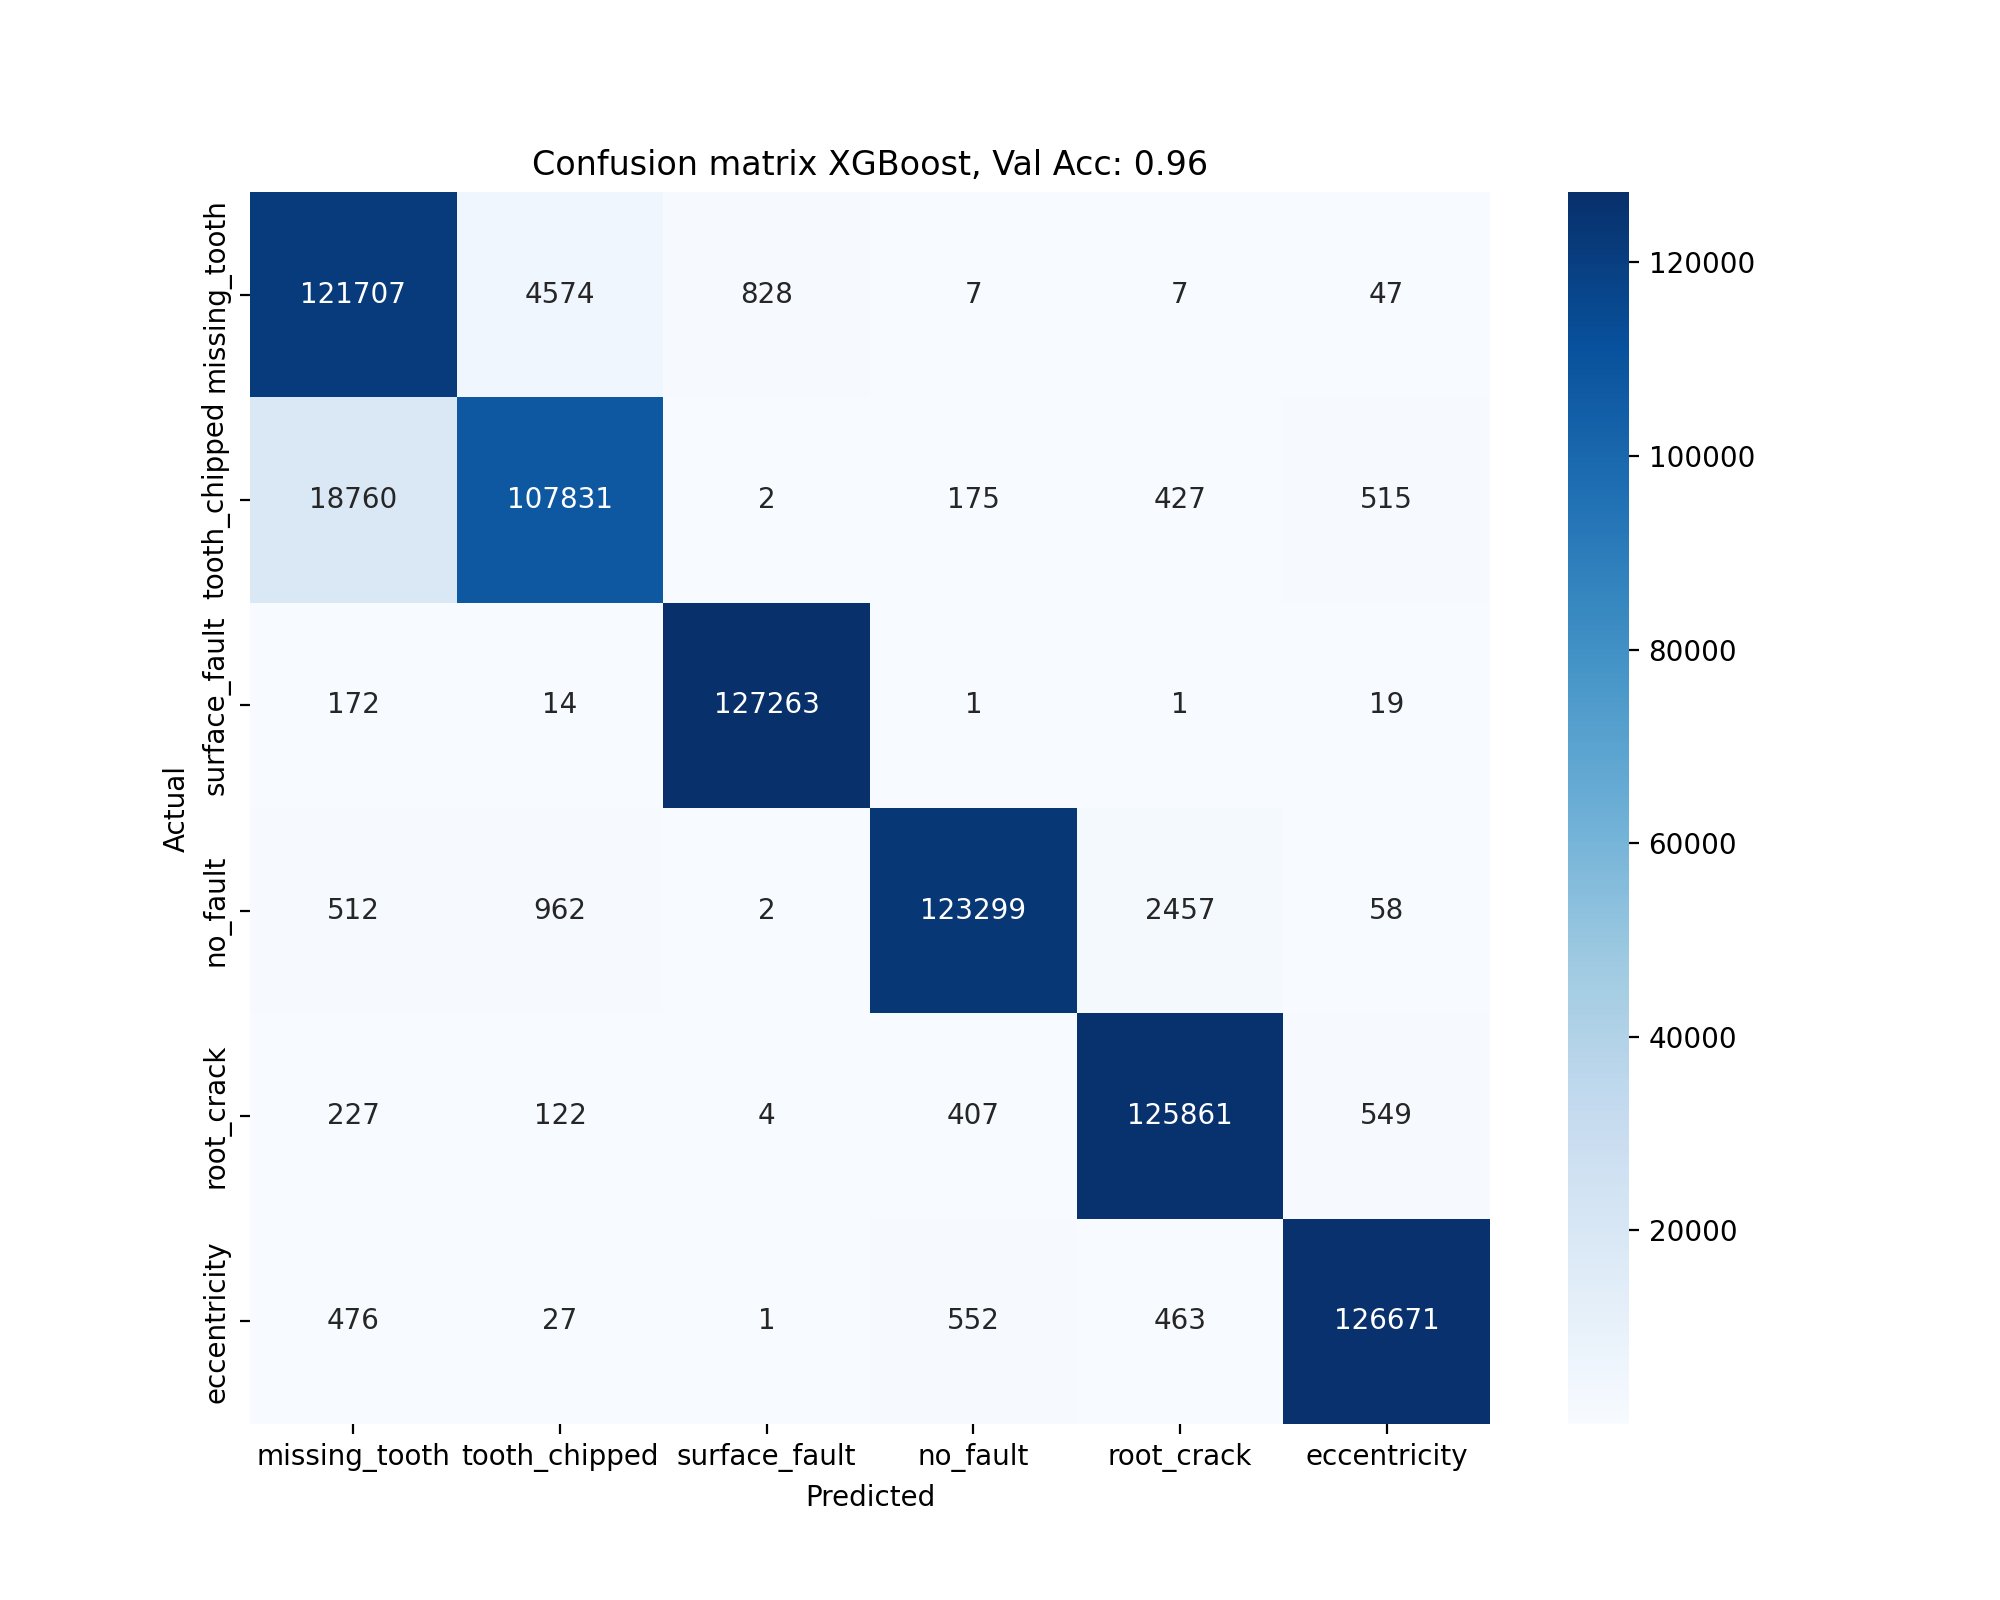

In [24]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, val_pred_xgb)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_xgb_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix XGBoost, Val Acc: {val_accuracy_xgb:.2f}')
plt.show()




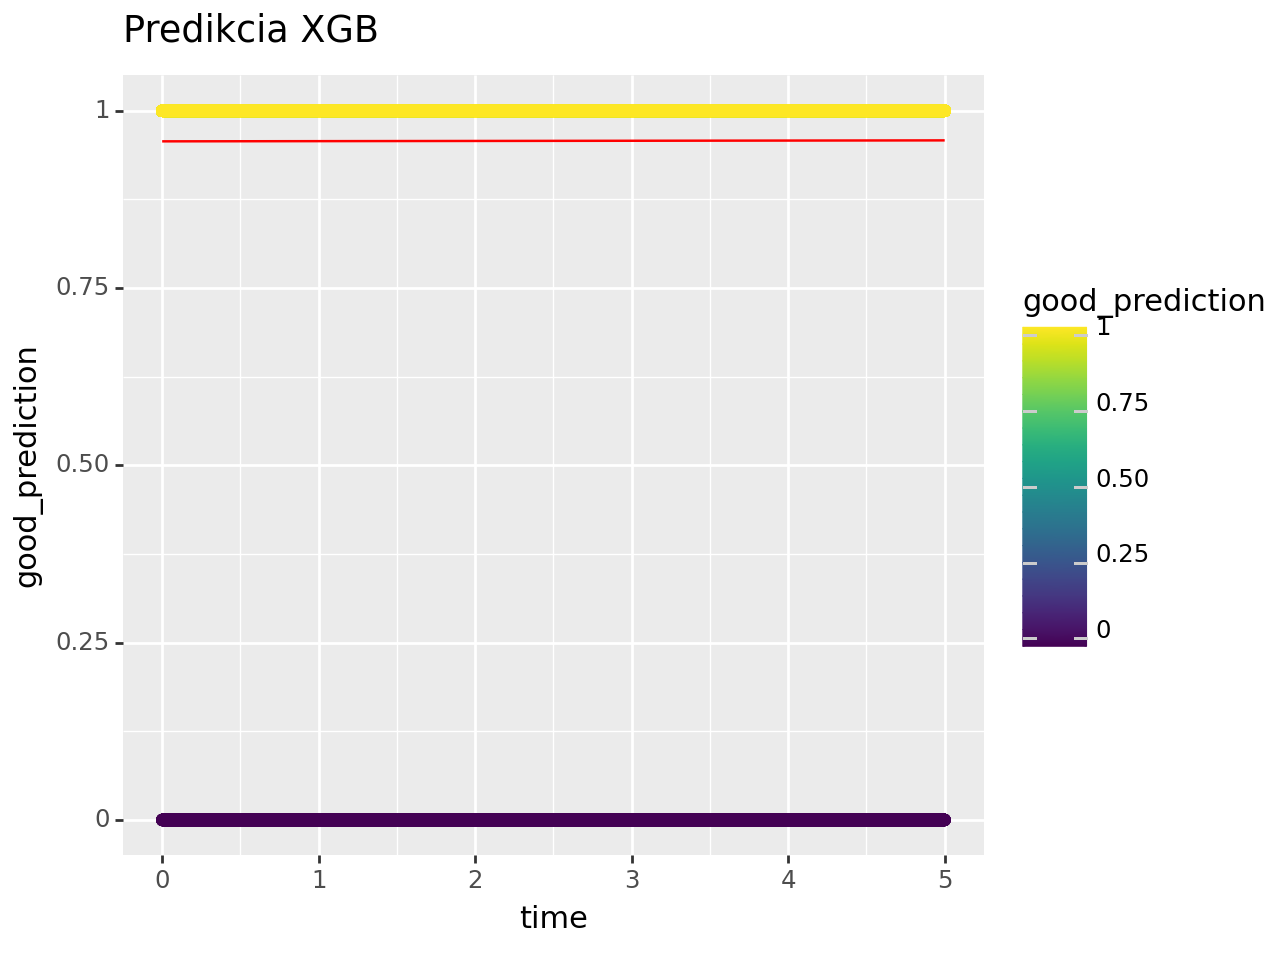

<Figure Size: (640 x 480)>

In [25]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_xgb
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia XGB'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [26]:
# Create a KNN model for classification using the df dataset print the accuracy of the model
param_distributions_knn = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

# Setup the model
knn_model = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_distributions_knn, 
    n_iter=1,  
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_knn.fit(X_train, y_train)

# Pick the best model
best_knn_model = random_search_knn.best_estimator_
best_knn_model.fit(X_train, y_train)

start_time4 = time()
# Predict the test set
y_pred = best_knn_model.predict(X_test)
training_time = time() - start_time4

# Calculate the accuracy
accuracy_knn = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_knn))

# For LightGBM example
val_pred_knn = best_knn_model.predict(X_val)
val_accuracy_knn = accuracy_score(y_val, val_pred_knn)


# Save the model to a file
model_name = f'knn_{accuracy_knn:.4f}'
model_directory = 'models'   
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_knn_model, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_knn}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_knn_model.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Accuracy: 0.8572


None

Model and metadata saved in models


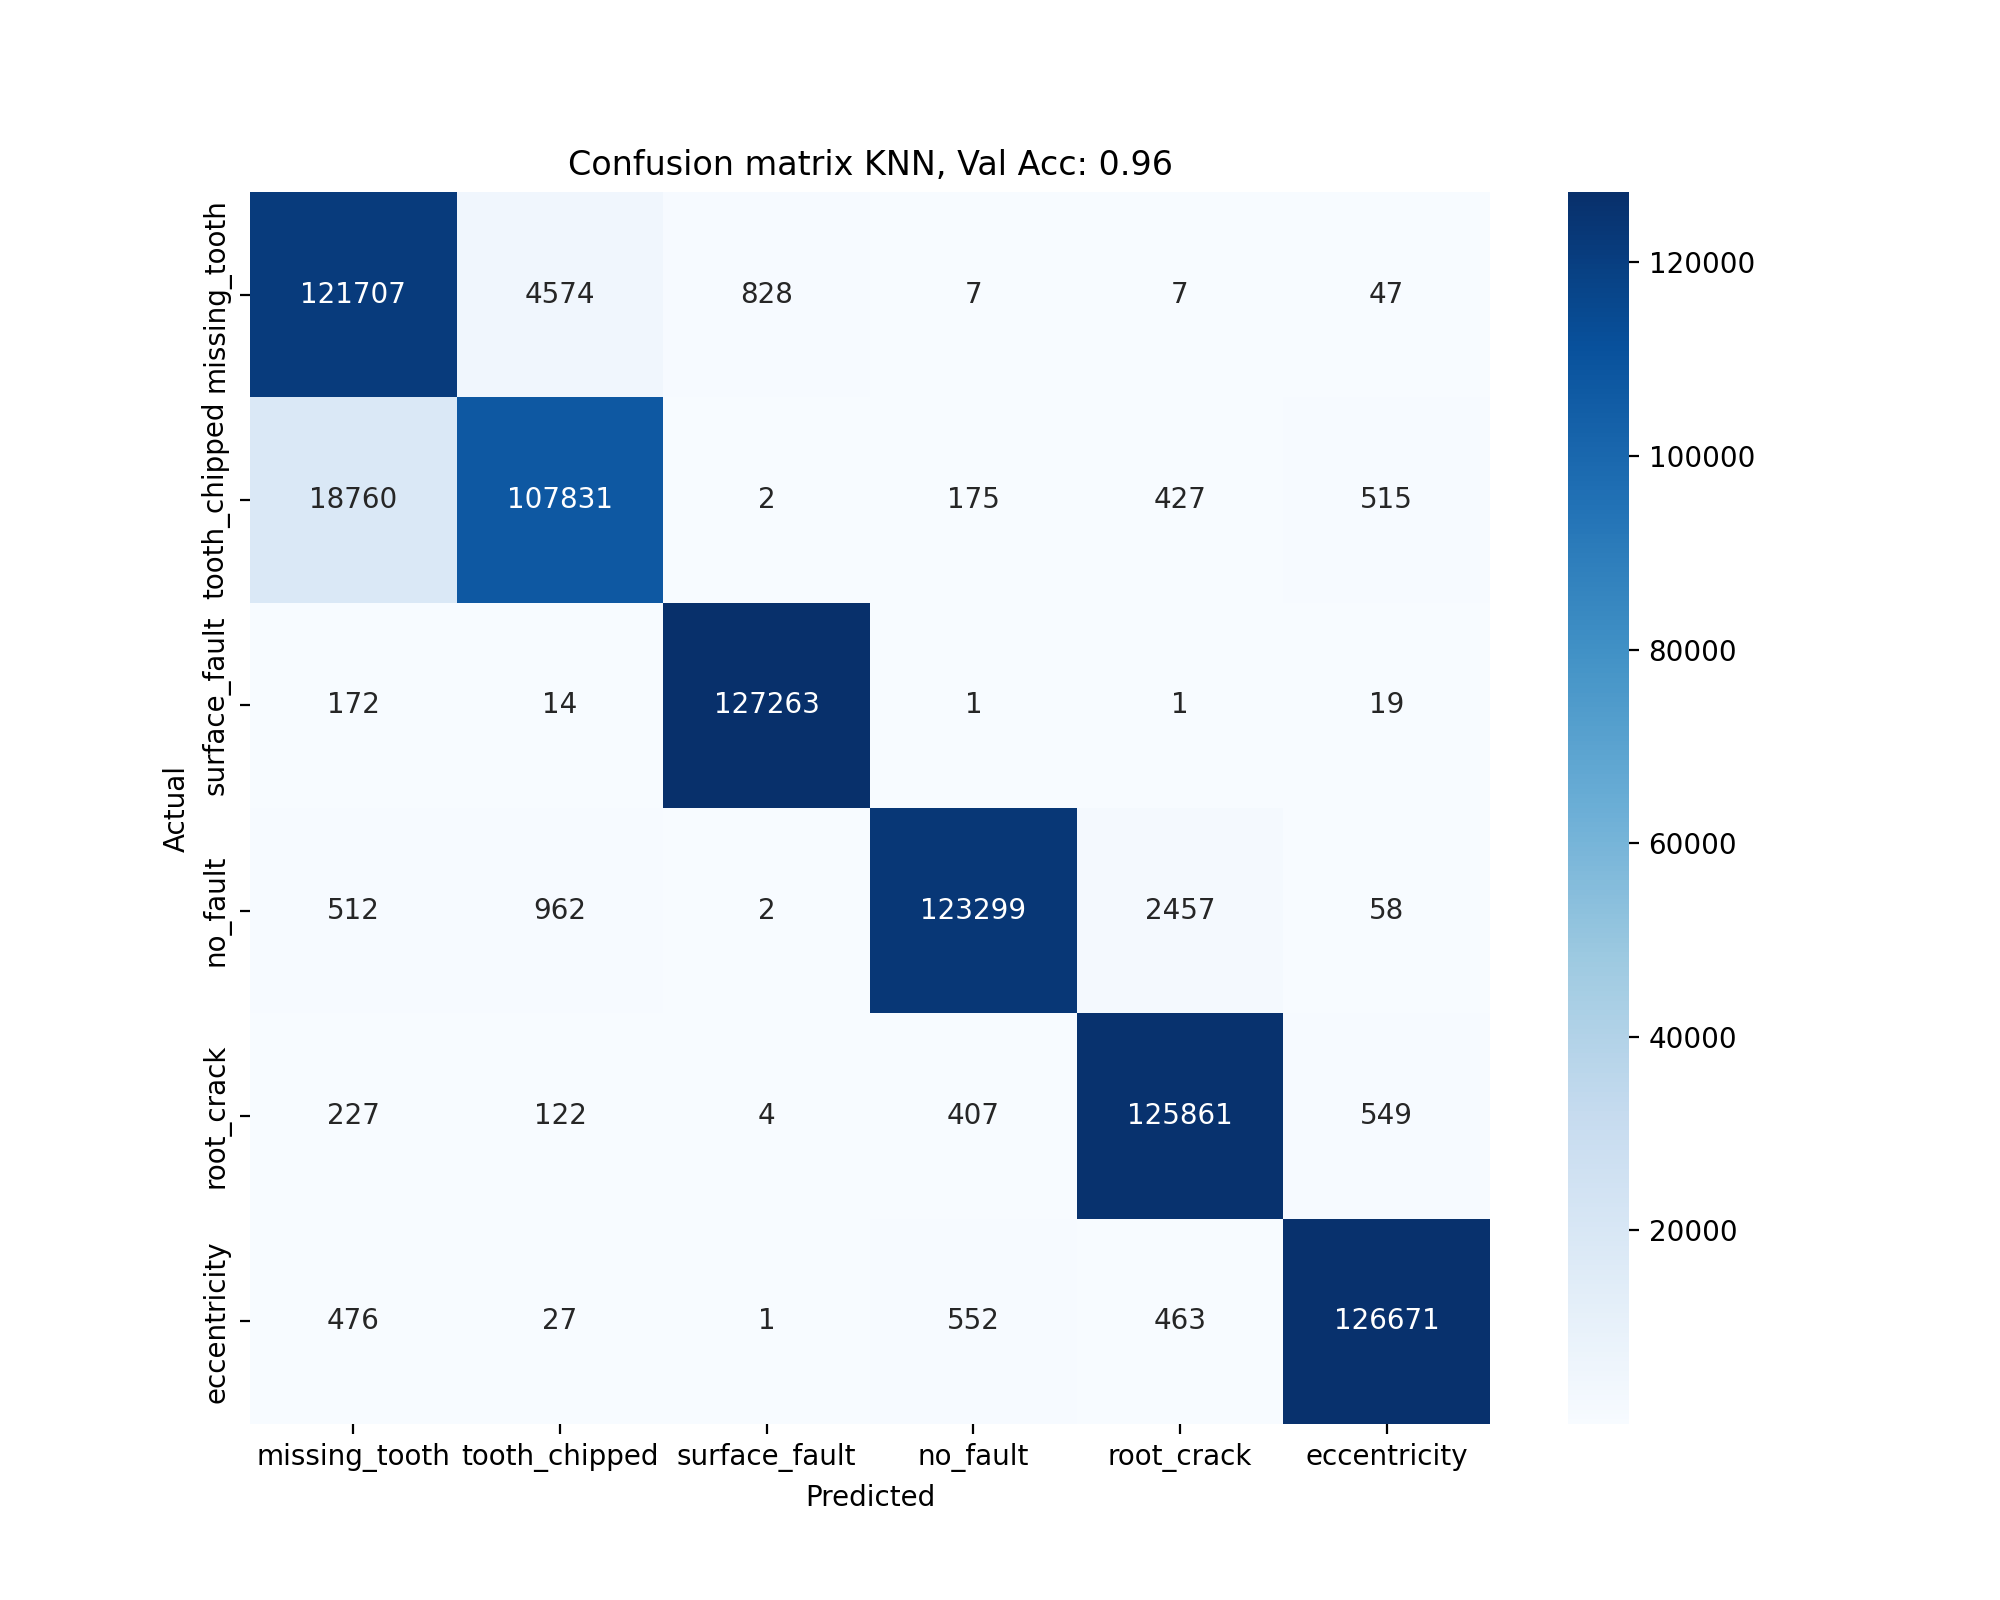

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, val_pred_xgb)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_knn_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix KNN, Val Acc: {val_accuracy_xgb:.2f}')
plt.show()

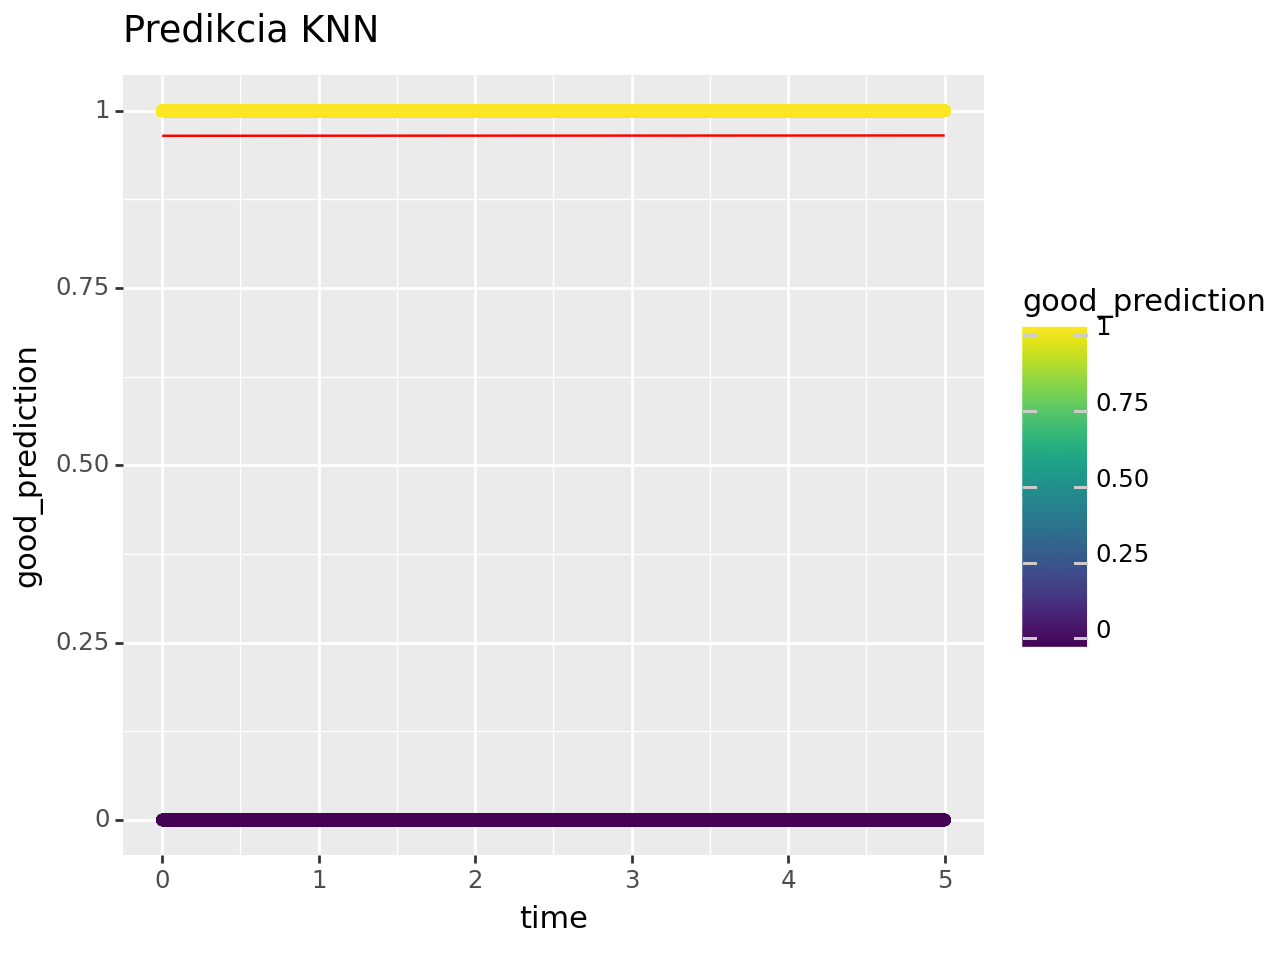

<Figure Size: (640 x 480)>

In [28]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_knn
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia KNN'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [29]:
# Random Forest
param_distributions_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Setup the model
rf_model = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_distributions_rf, 
    n_iter=1,  
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_rf.fit(X_train, y_train)

# Pick the best model
best_rf_model = random_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

start_time5 = time()
# Predict the test set
y_pred = best_rf_model.predict(X_test)
start_time = time() - start_time5

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_rf))

# For LightGBM example
val_pred_rf = best_rf_model.predict(X_val)
val_accuracy_rf = accuracy_score(y_val, val_pred_rf)

# Print the validation accuracy
print(f'Validation Accuracy for RandomForest: {val_accuracy_rf}')

# Save the model to a file
model_name = f'random_forest_{accuracy_rf:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_rf_model, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_rf}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_rf_model.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Accuracy: 0.8434666666666667


None

Validation Accuracy for RandomForest: 0.967116339869281
Model and metadata saved in models


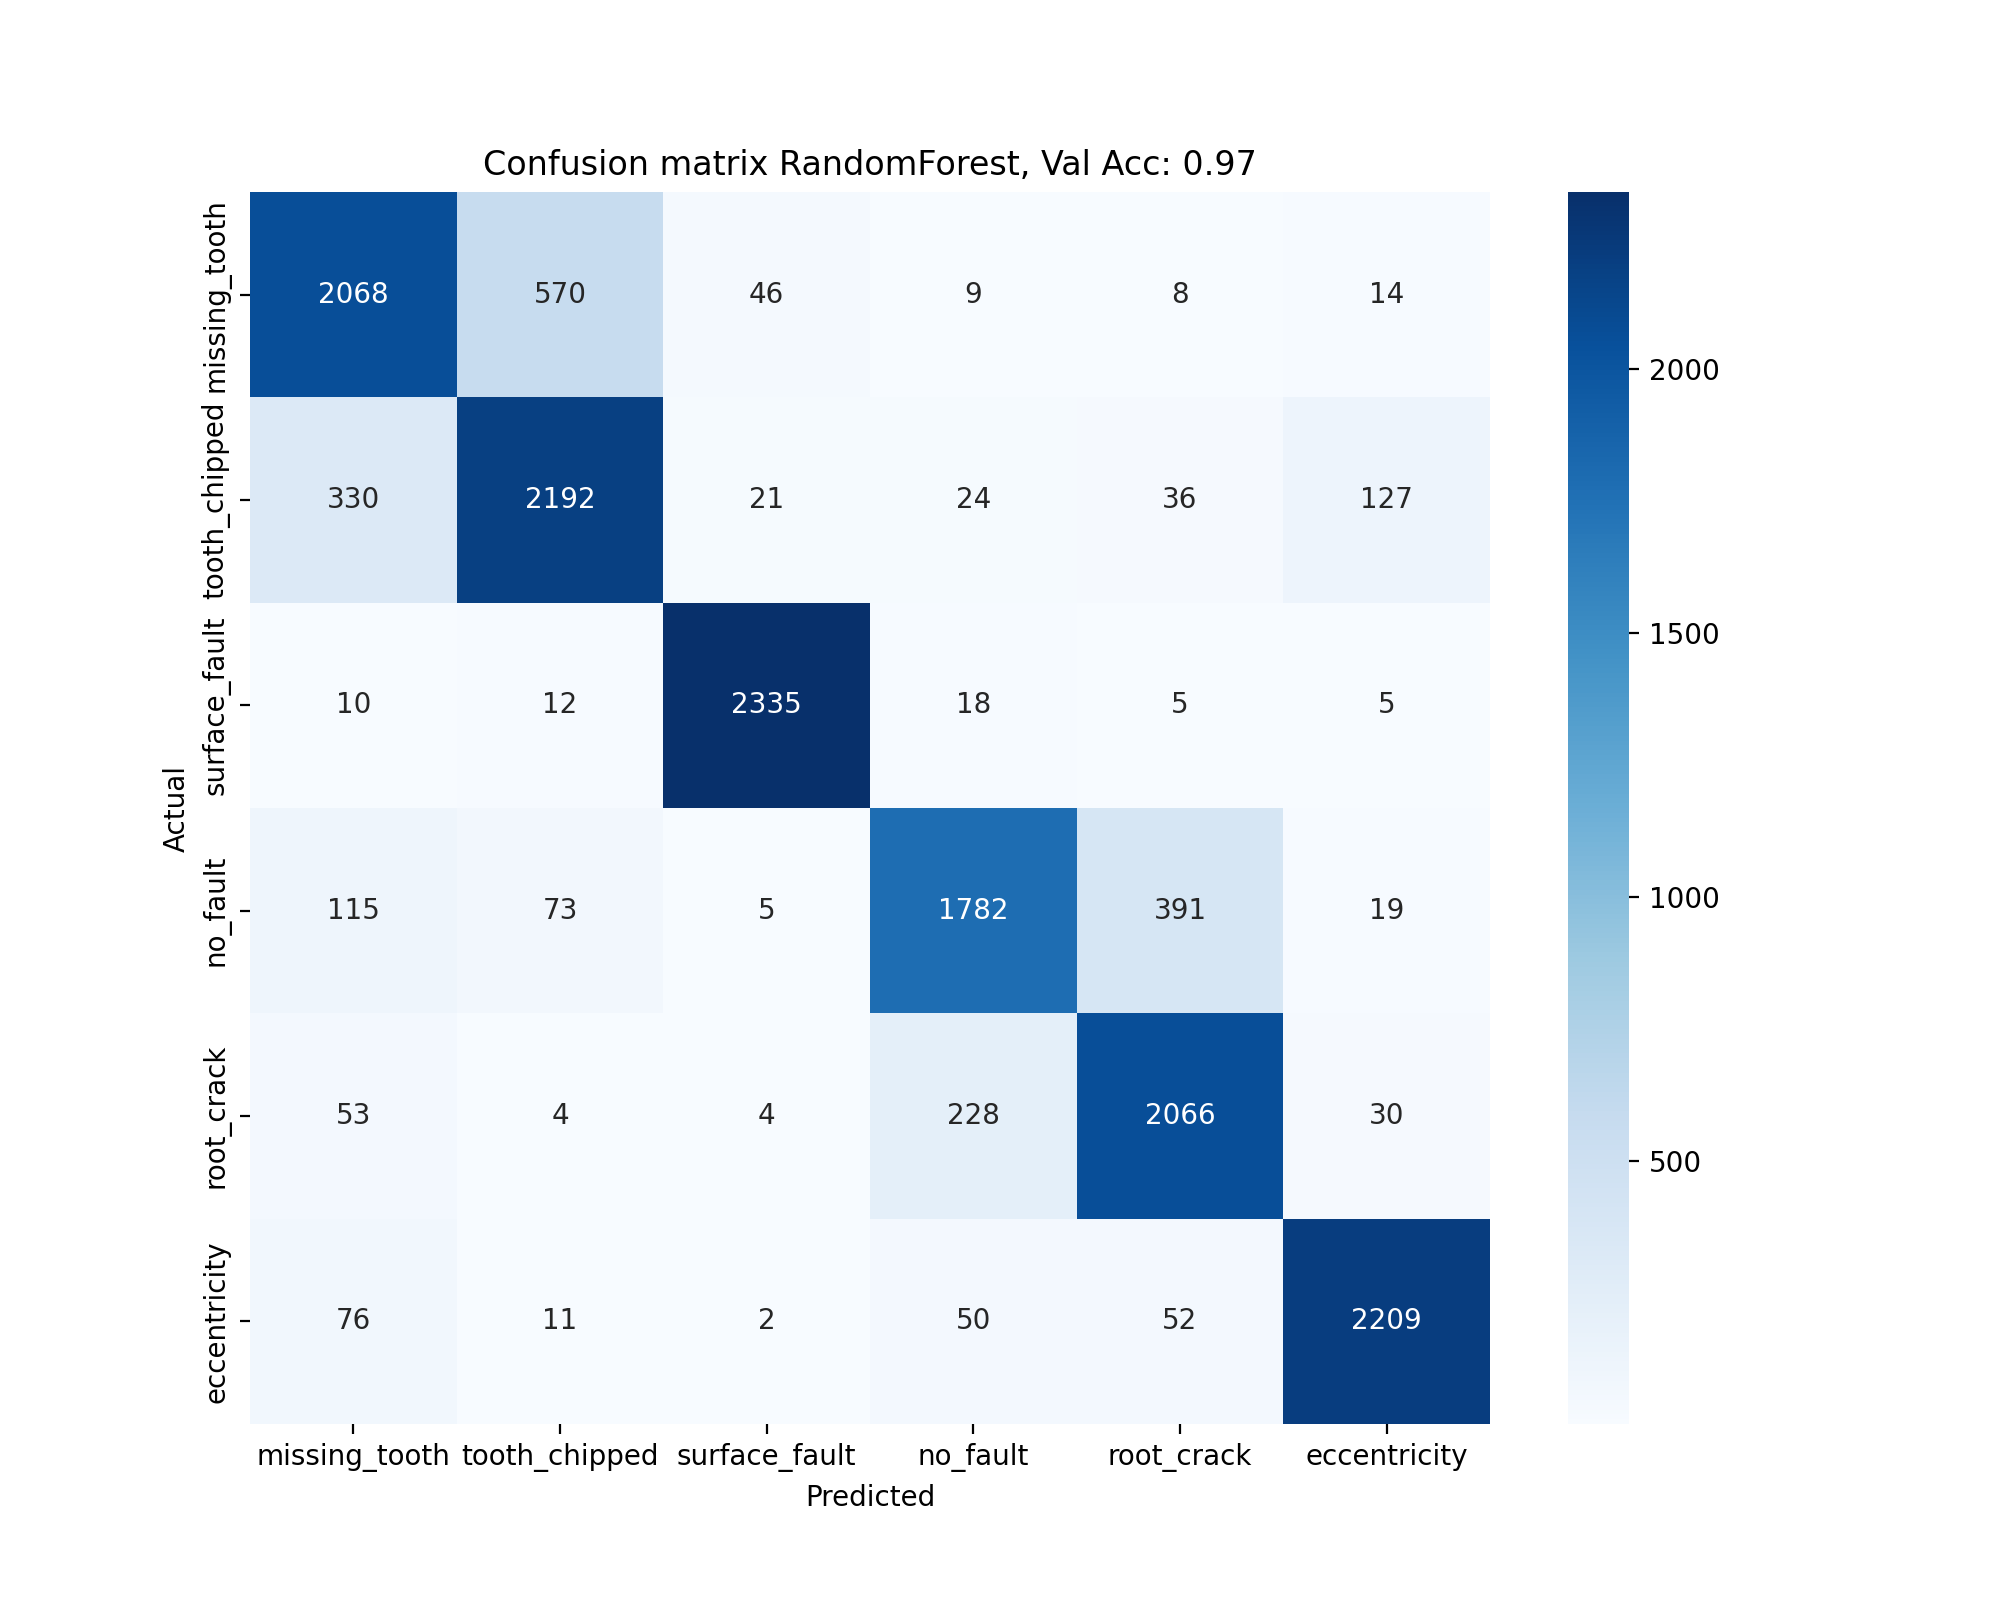

In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_rf_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix RandomForest, Val Acc: {val_accuracy_rf:.2f}')
plt.show()

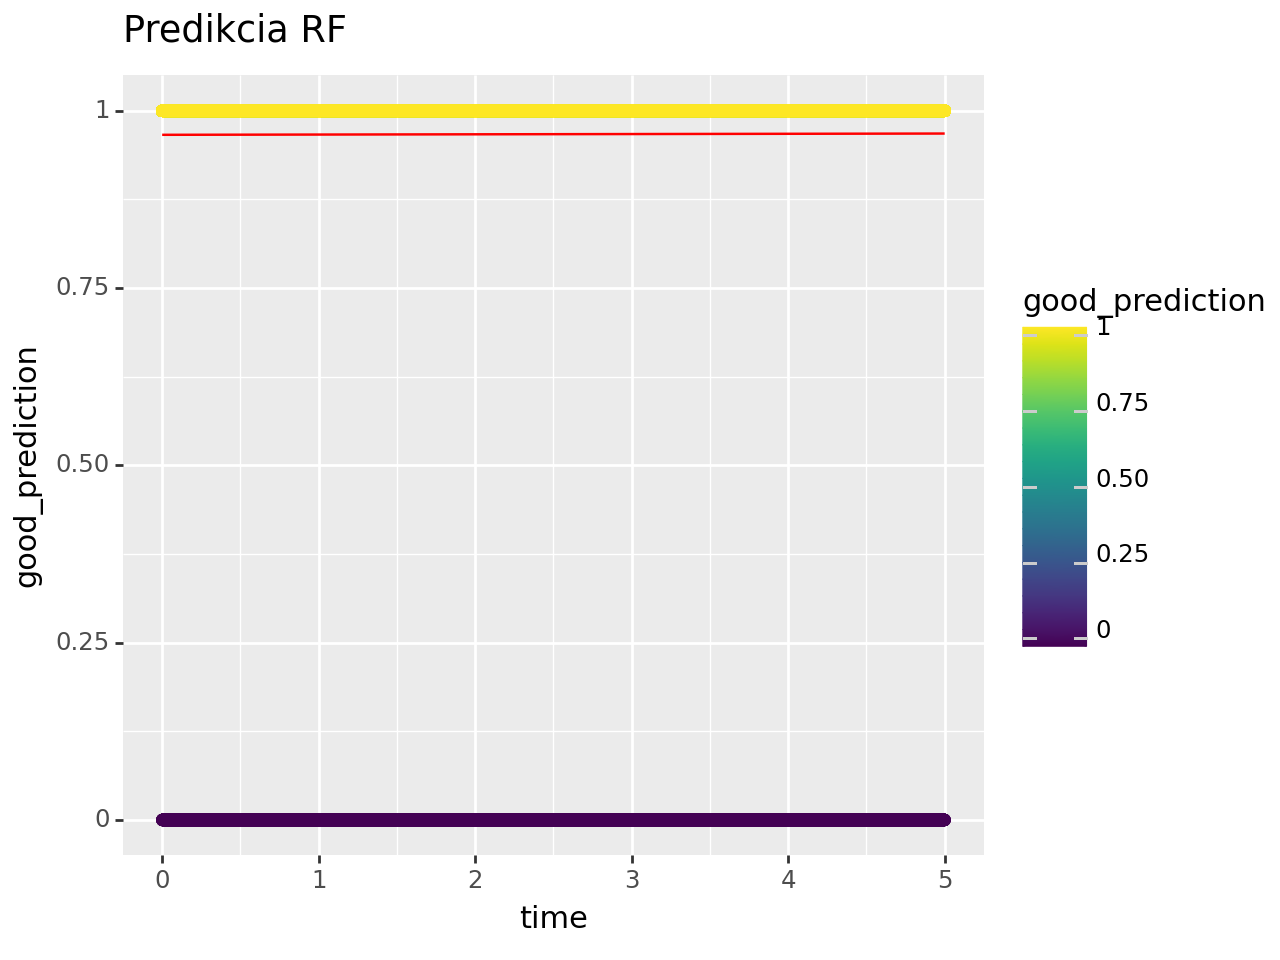

<Figure Size: (640 x 480)>

In [31]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_rf
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia RF'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [32]:
# Create a decision tree model for classification using the df dataset print the accuracy of the model
param_distributions_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

# Setup the model
dt_model = DecisionTreeClassifier()
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_distributions_dt, 
    n_iter=1,  
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_dt.fit(X_train, y_train)

# Pick the best model
best_dt_model = random_search_dt.best_estimator_
best_dt_model.fit(X_train, y_train)

start_time6 = time()
# Predict the test set
y_pred = best_dt_model.predict(X_test)
start_time = time() - start_time6

# Calculate the accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_dt))

# For LightGBM example
val_pred_dt = best_dt_model.predict(X_val)
val_accuracy_dt = accuracy_score(y_val, val_pred_dt)

# Print the validation accuracy
print(f'Validation Accuracy for DecisionTree: {val_accuracy_dt}')

# Save the model to a file
model_name = f'decision_tree_{accuracy_dt:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_dt_model, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_dt}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_dt_model.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Accuracy: 0.8208


None

Validation Accuracy for DecisionTree: 0.9054366013071895
Model and metadata saved in models


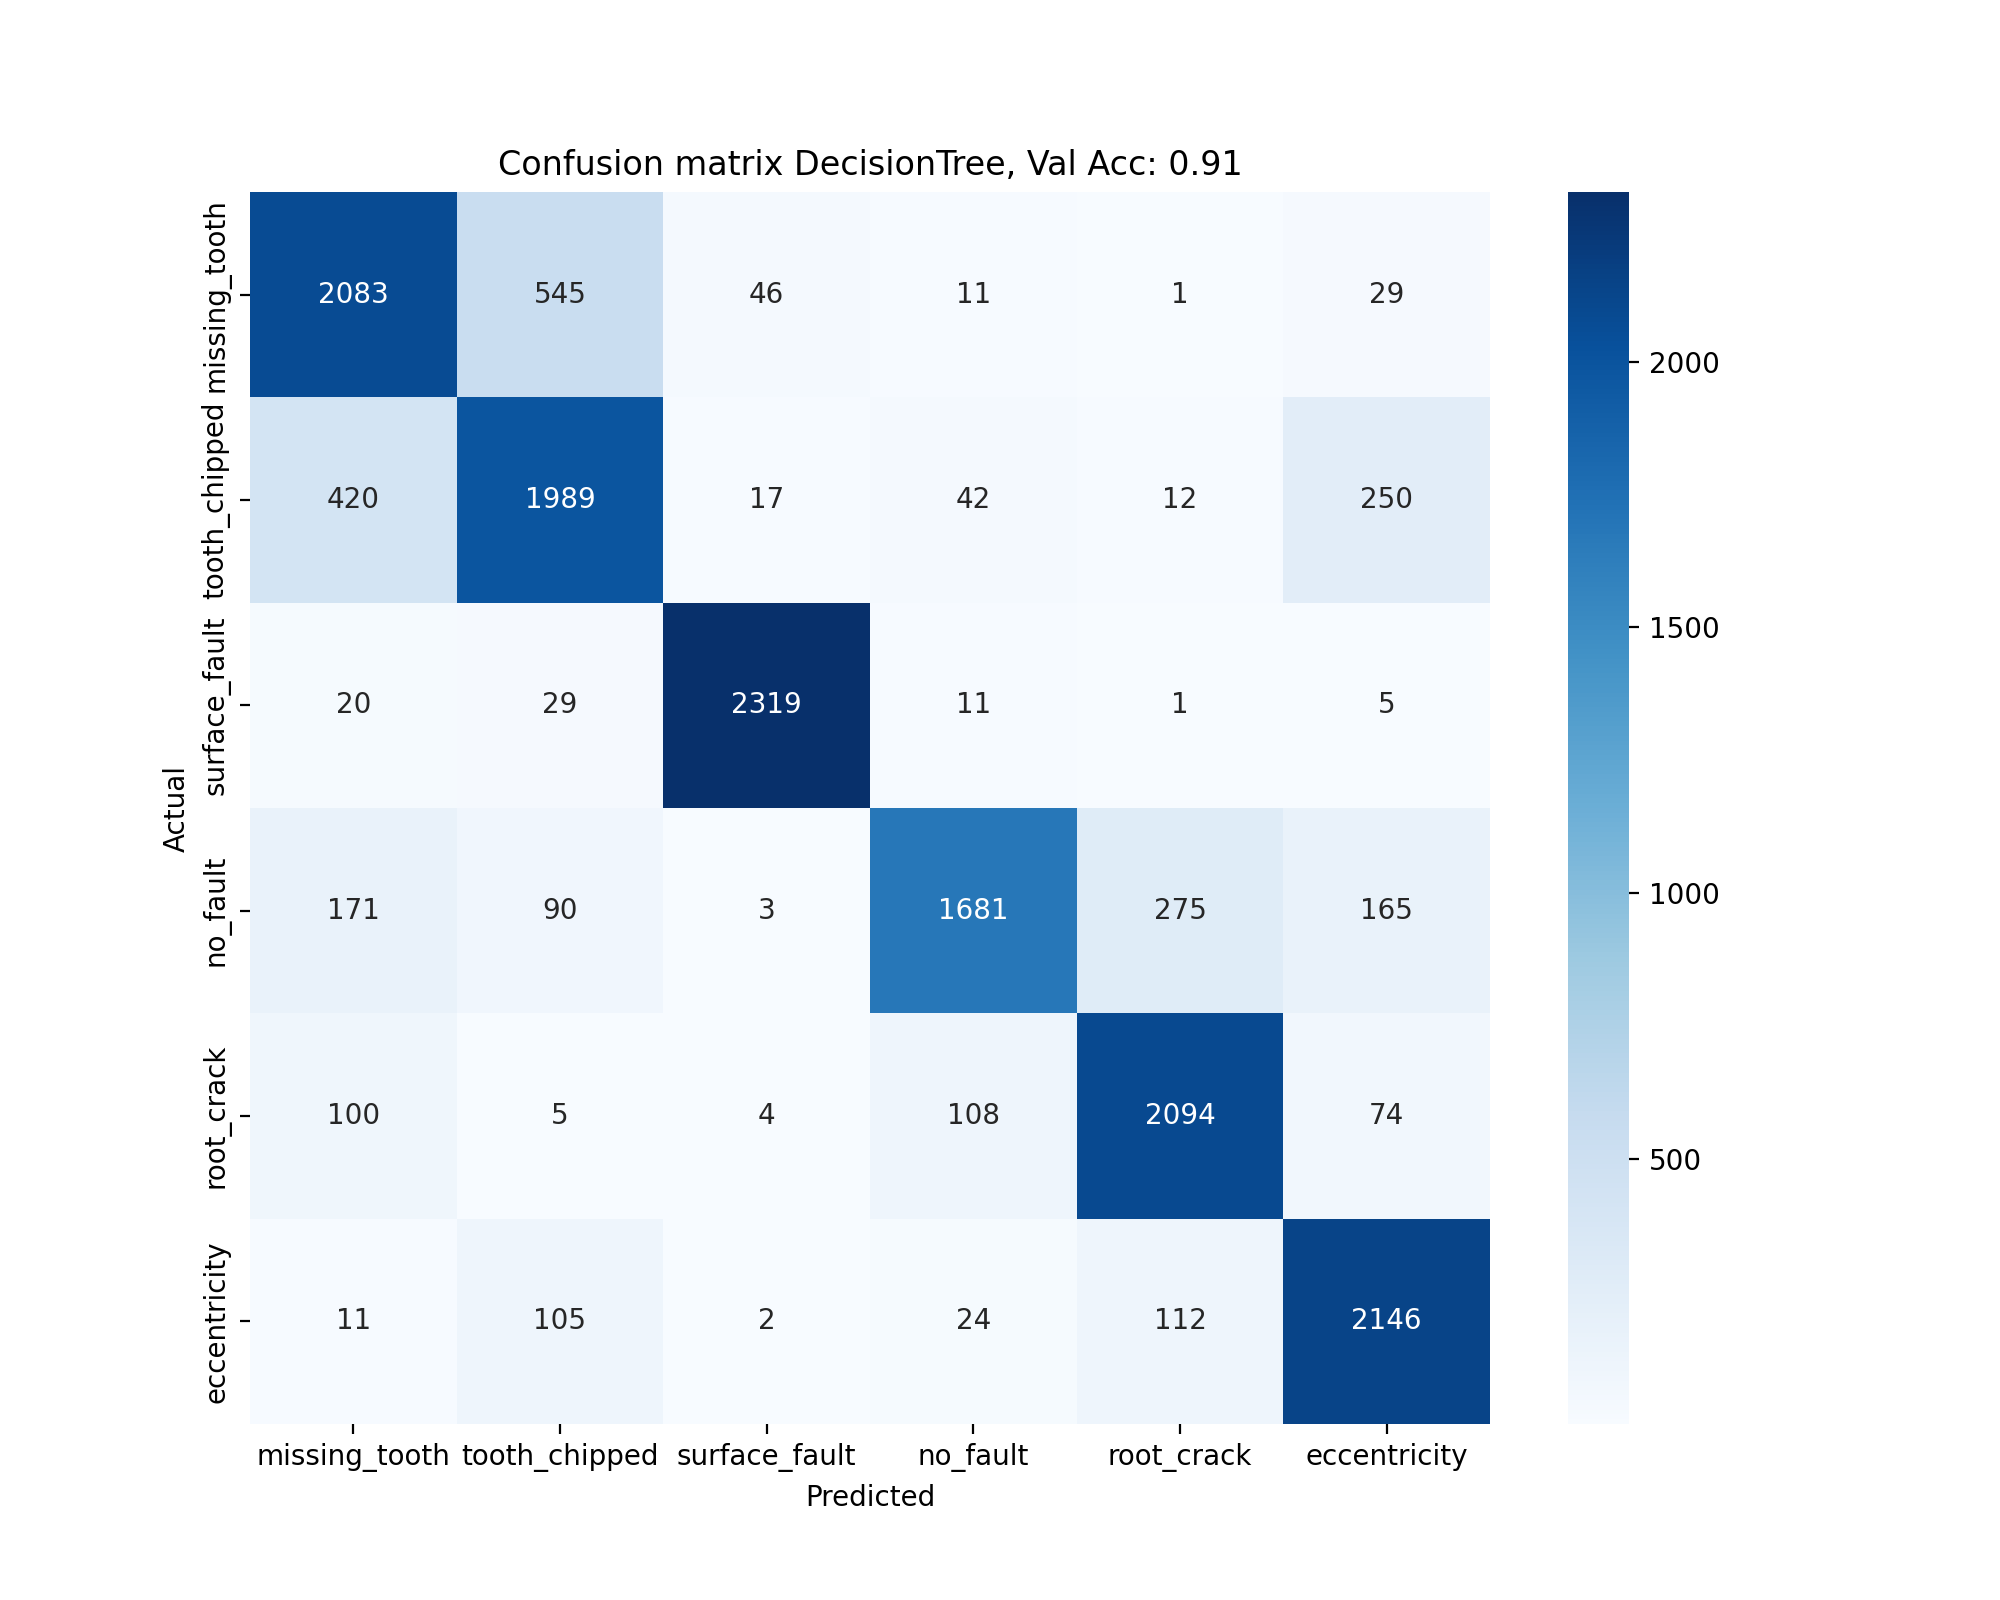

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_dt_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix DecisionTree, Val Acc: {val_accuracy_dt:.2f}')
plt.show()

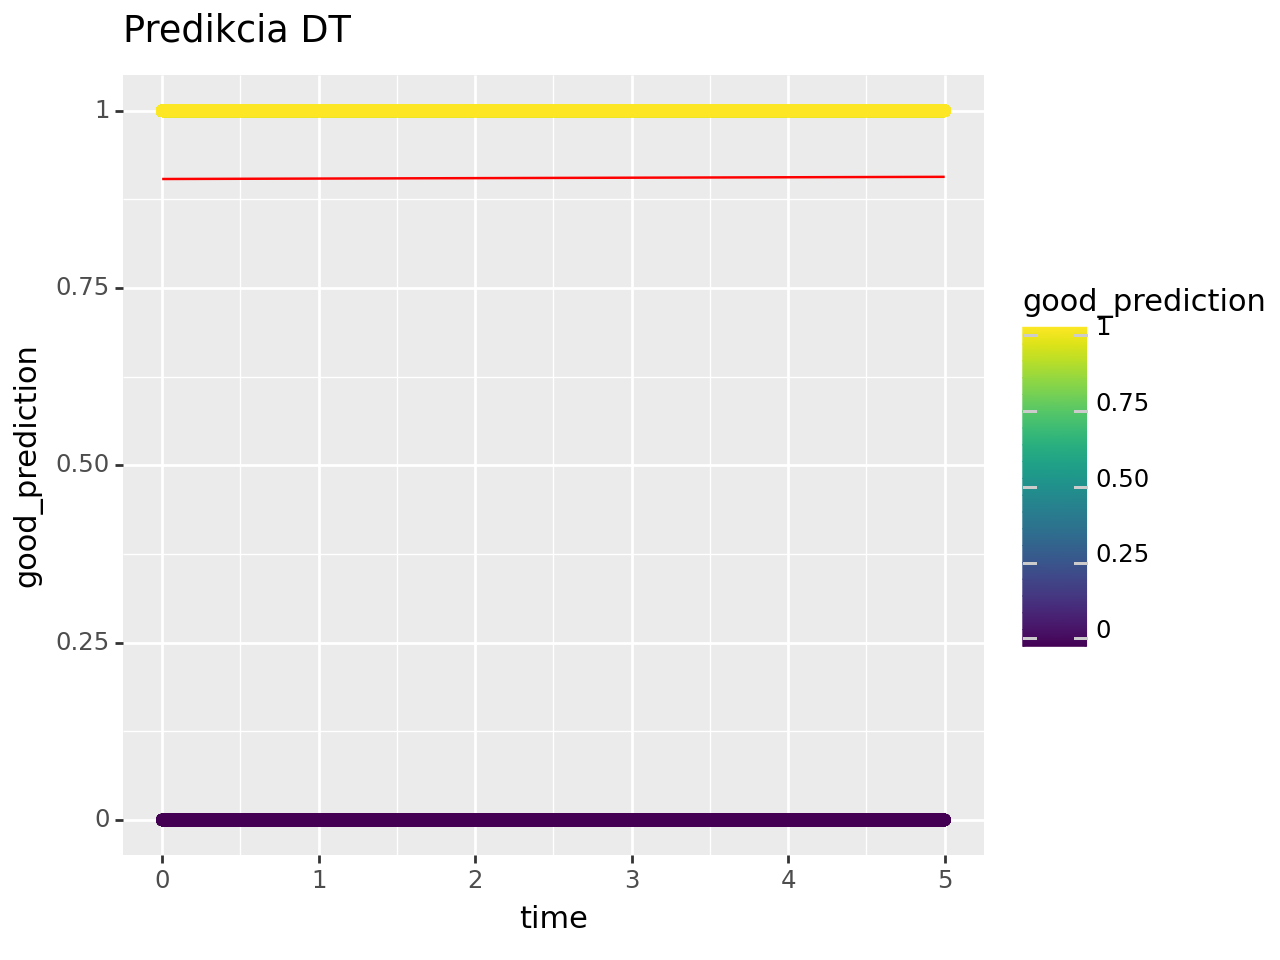

<Figure Size: (640 x 480)>

In [34]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_dt
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class


from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia DT'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [35]:
# Create SVM
param_distributions_svm = {
    'C': [0.1],
    'gamma': ['scale'],
    'kernel': ['rbf'],
    'svc__class_weight': ['balanced'], 
    'decision_function_shape' : ['ovr',]
}

# Create the SVM model with specific parameters
random_search_svm = SVC(
        C=0.1, 
        gamma='scale', 
        kernel='rbf', 
        class_weight='balanced', 
        decision_function_shape='ovr'
    )

random_search_svm.fit(X_train, y_train)

# Pick the best model
best_svm_model = random_search_svm
best_svm_model.fit(X_train, y_train)

start_time7 = time()
# Predict the test set
y_pred = best_svm_model.predict(X_test)
start_time = time() - start_time7

# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_svm))

# Print the validation accuracy
display(print(f'Validation Accuracy for SVM: {accuracy_svm}'))

# Save the model to a file
model_name = f'svm_{accuracy_svm:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_svm_model, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_svm}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_svm_model.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Accuracy: 0.8468


None

Validation Accuracy for SVM: 0.8468


None

Model and metadata saved in models


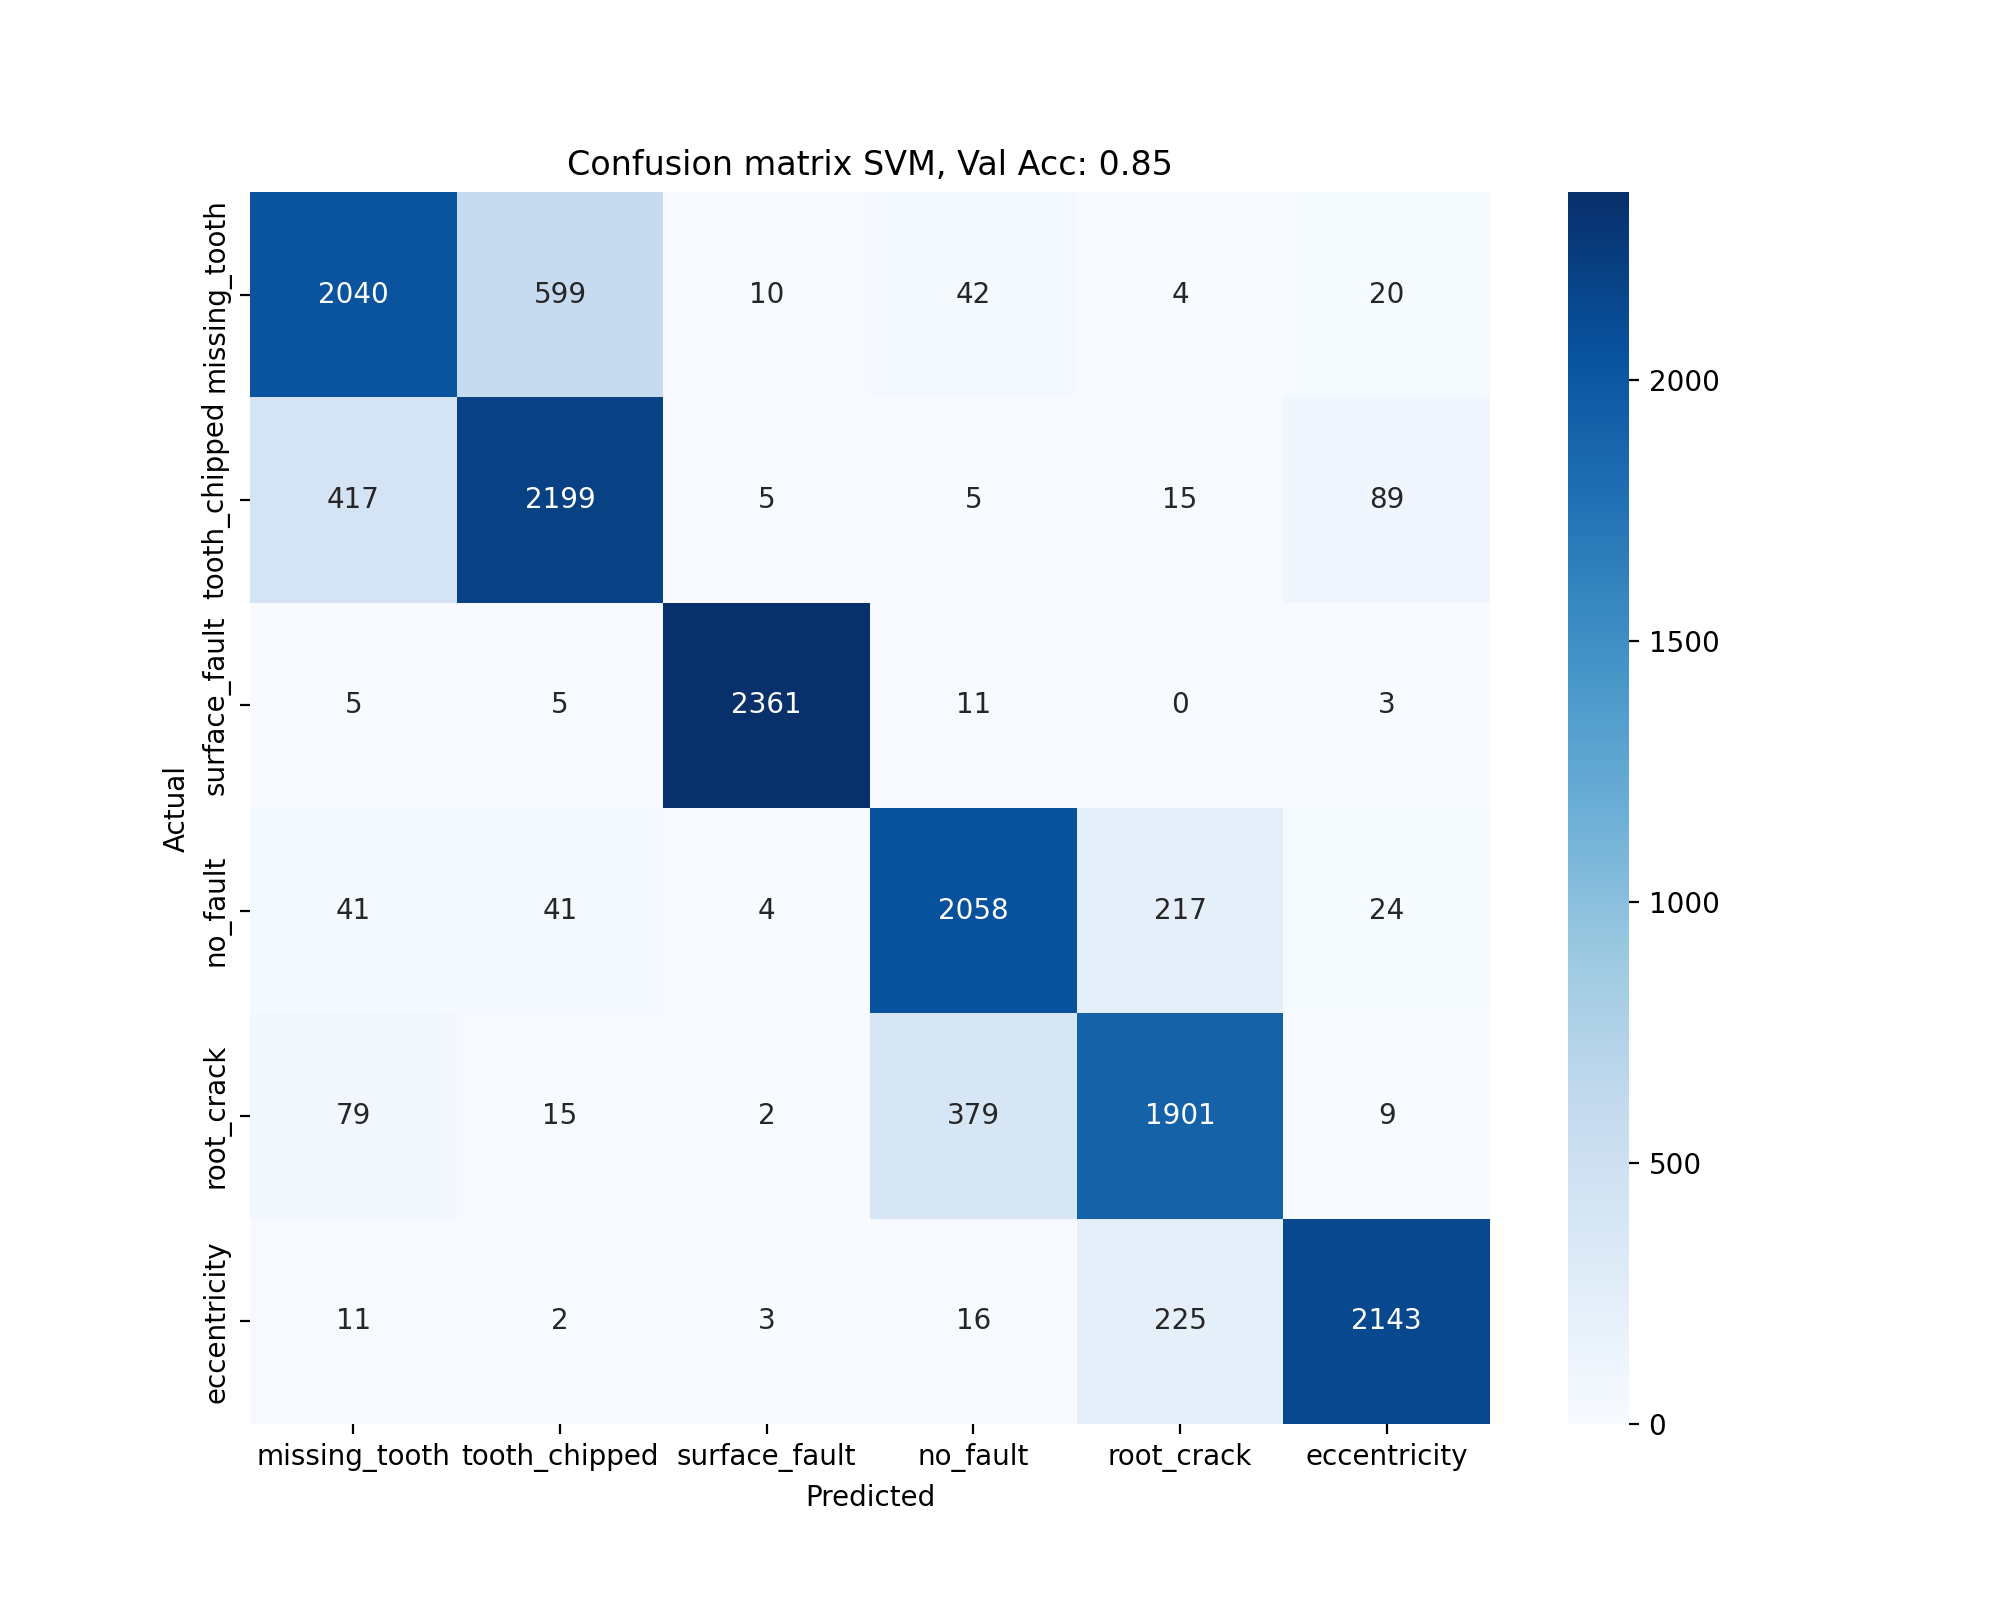

In [36]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_svm_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix SVM, Val Acc: {accuracy_svm:.2f}')
plt.show()

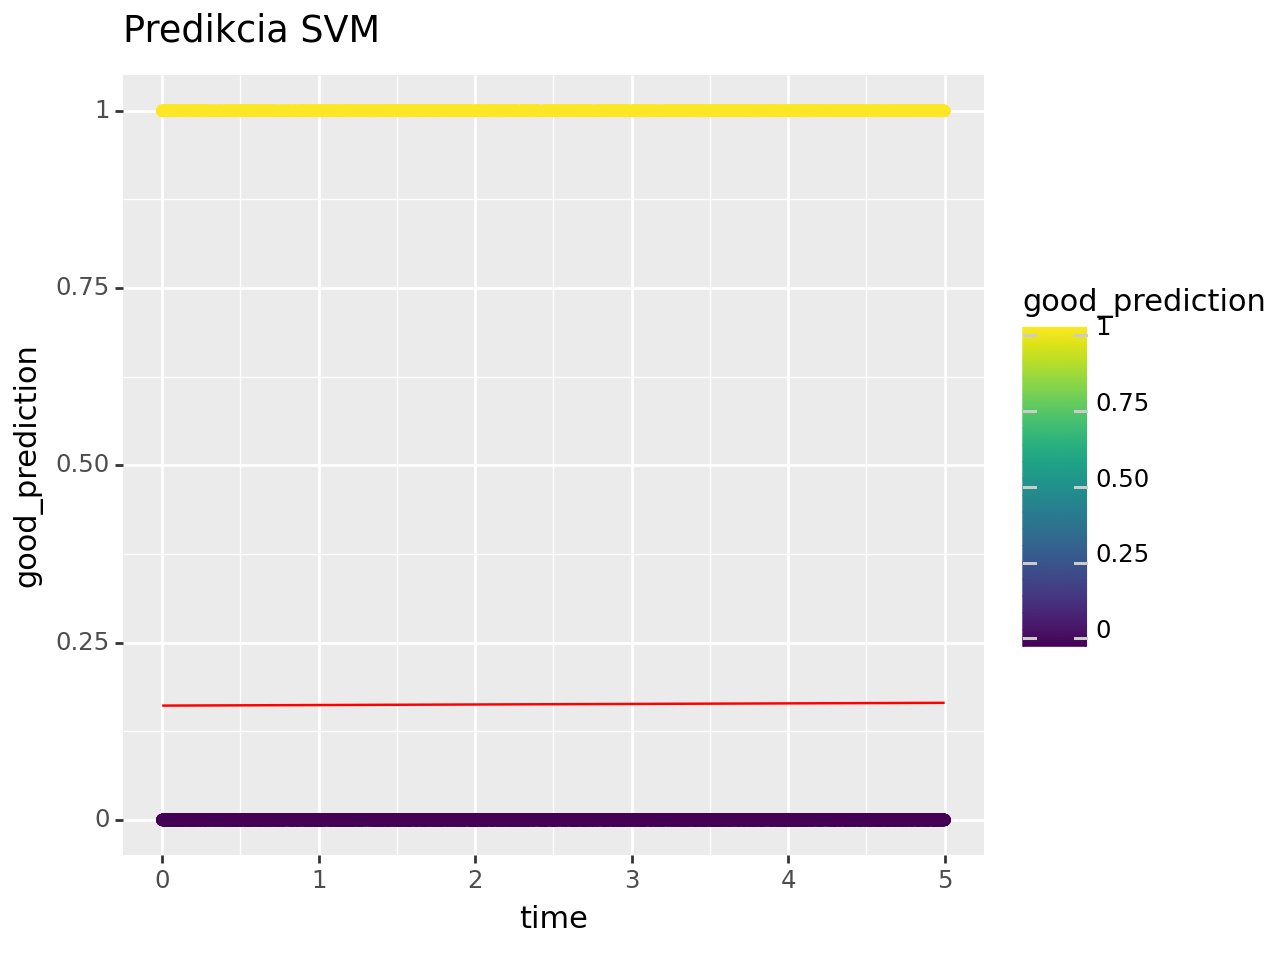

<Figure Size: (640 x 480)>

In [37]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia SVM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [38]:
# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model
param_distributions_mlp = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.001],
    'learning_rate': ['constant'],
}

# Setup the model
mlp_model = MLPClassifier()
random_search_mlp = RandomizedSearchCV(mlp_model, param_distributions=param_distributions_mlp, 
    n_iter=1,  
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_mlp.fit(X_train, y_train)

# Pick the best model
best_mlp_model = random_search_mlp.best_estimator_
best_mlp_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_mlp_model.predict(X_test)

# Calculate the accuracy
accuracy_mlp = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_mlp))

# For LightGBM example
start_time8 = time()
val_pred_mlp = best_mlp_model.predict(X_val)
training_time = time() - start_time8
val_accuracy_mlp = accuracy_score(y_val, val_pred_mlp)

# Print the validation accuracy
print(f'Validation Accuracy for MLP: {val_accuracy_mlp}')

# Save the model to a file
model_name = f'mlp_{accuracy_mlp:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_mlp_model, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_mlp}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_mlp_model.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Accuracy: 0.8450666666666666


None

Validation Accuracy for MLP: 0.9591477124183007
Model and metadata saved in models


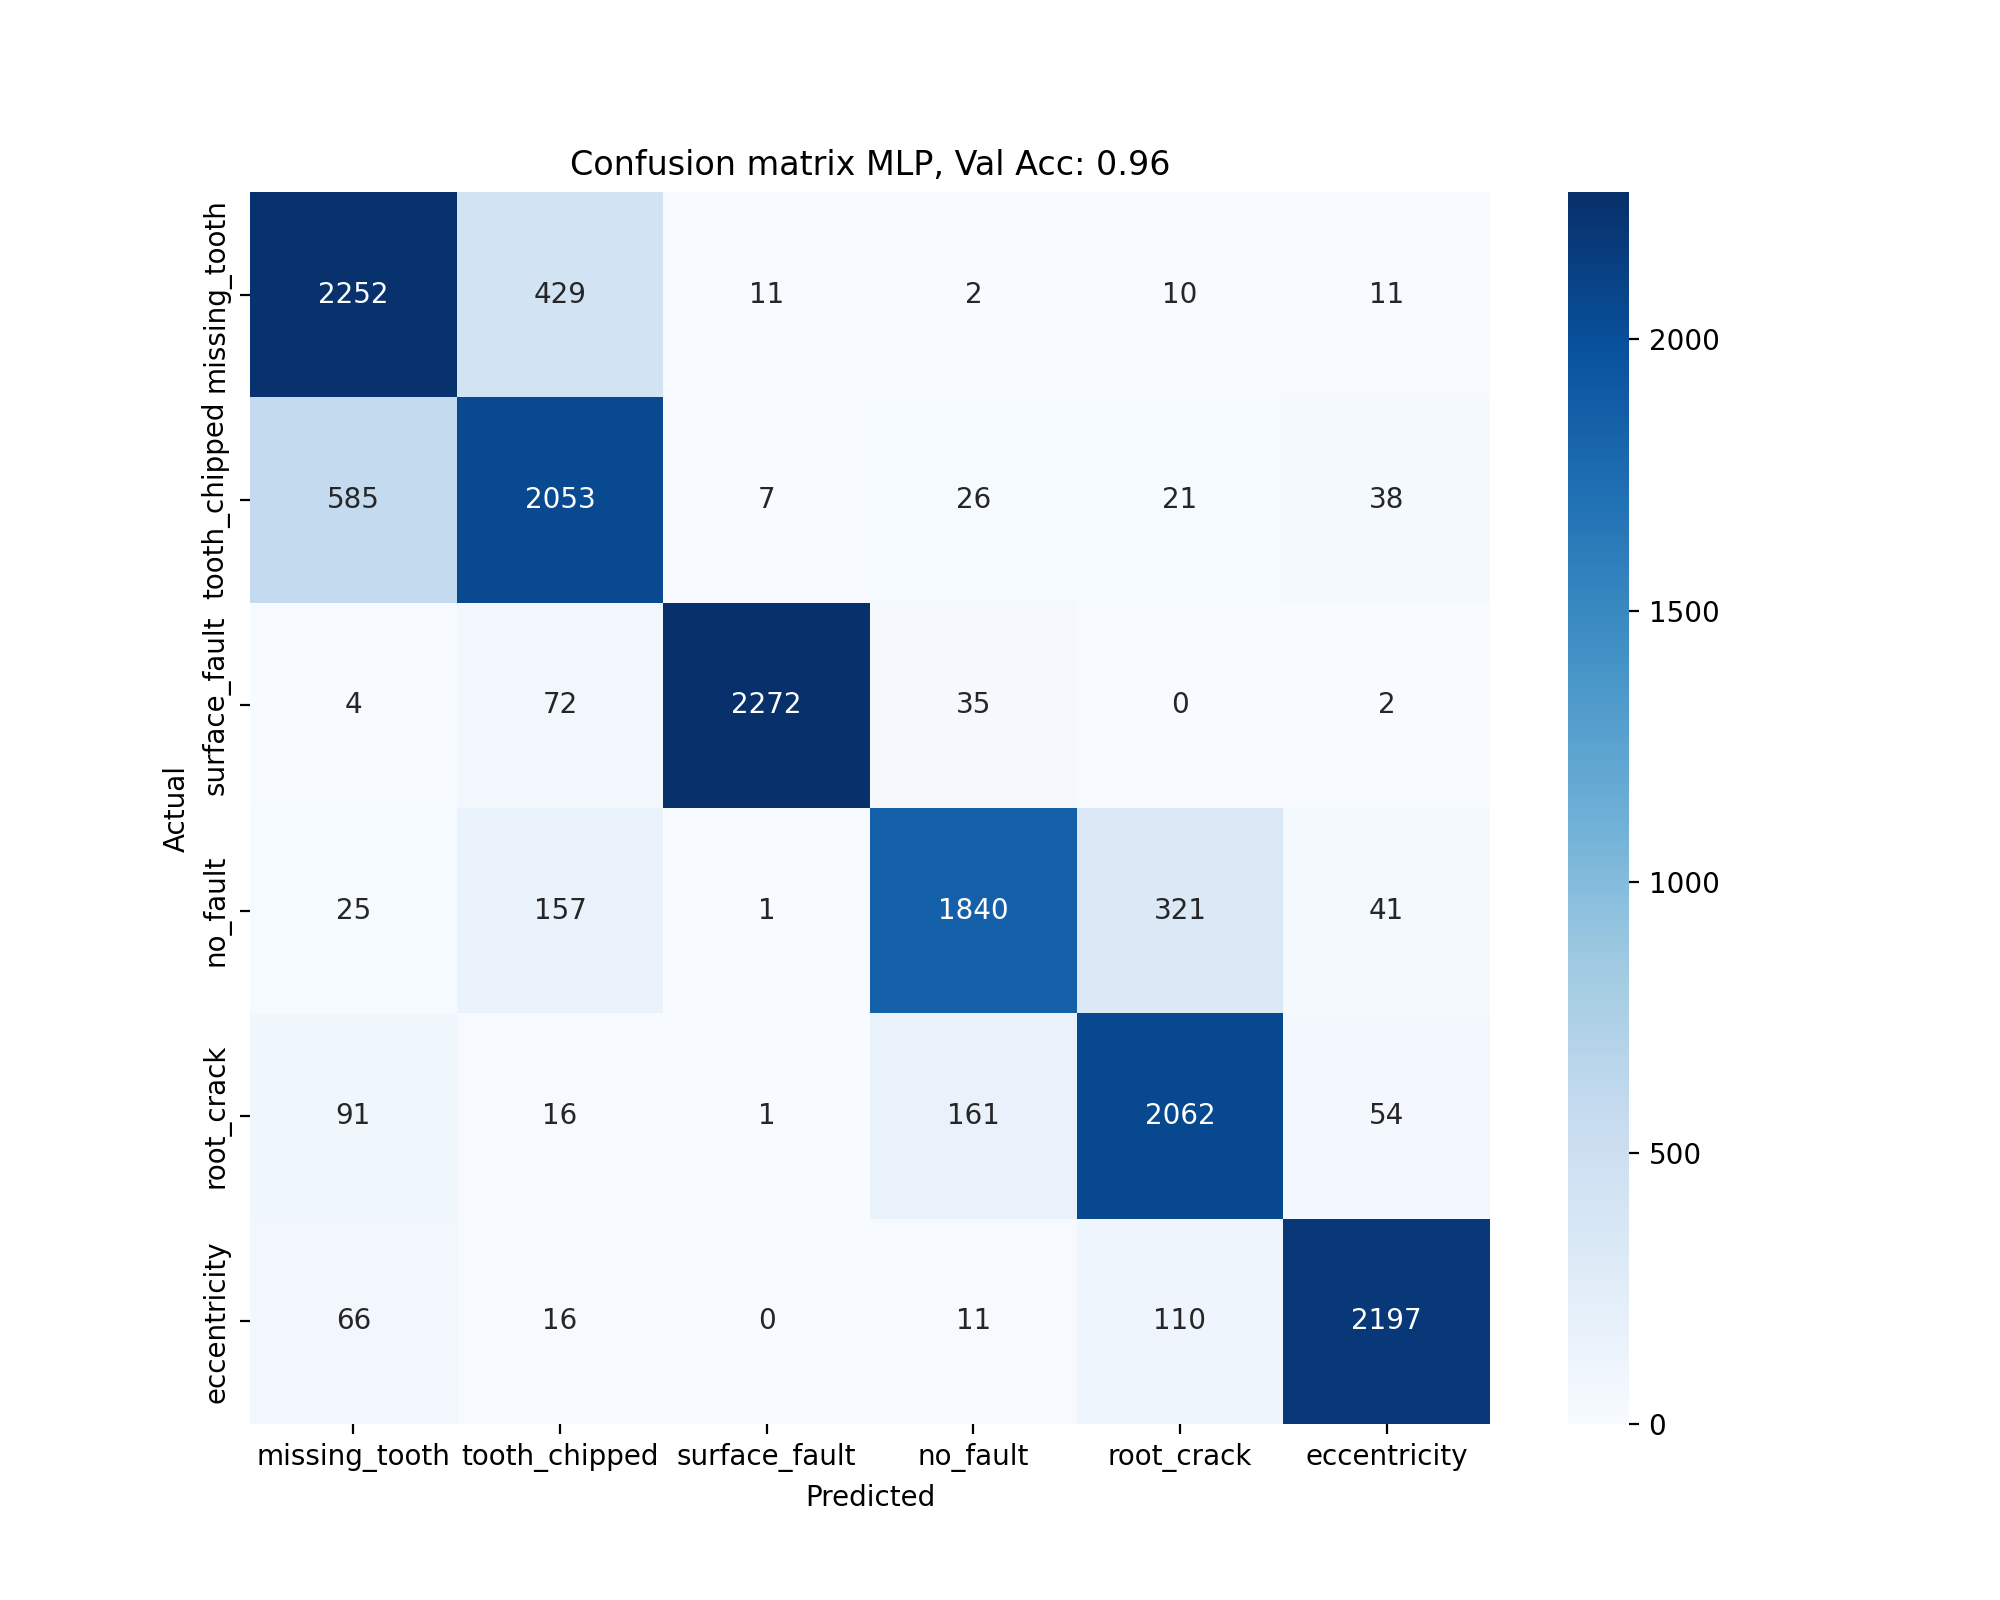

In [39]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_mlp_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix MLP, Val Acc: {val_accuracy_mlp:.2f}')
plt.show()

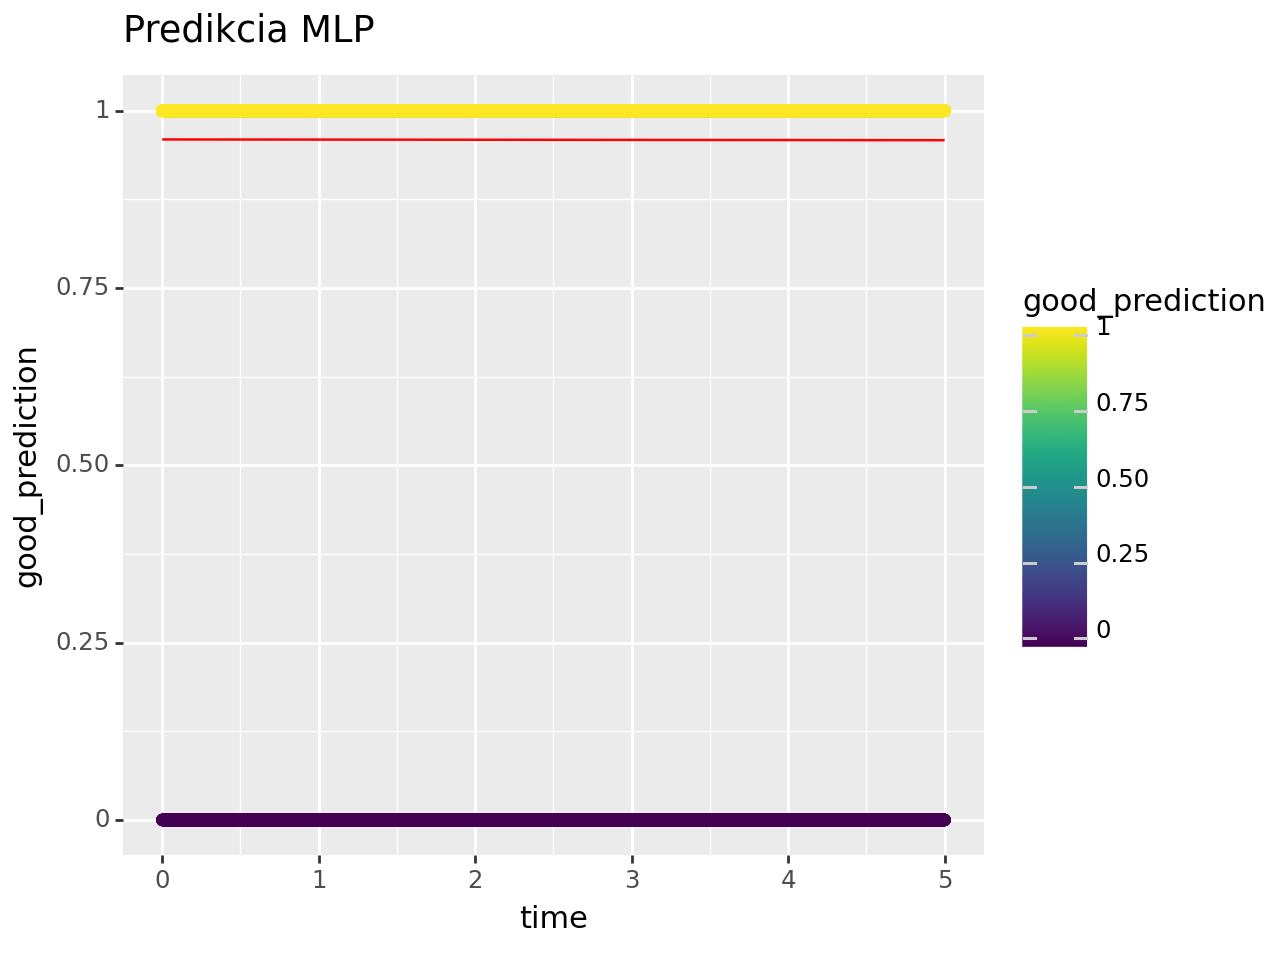

<Figure Size: (640 x 480)>

In [40]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_mlp
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia MLP'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


Best model: knn, Validation Accuracy: 0.8572


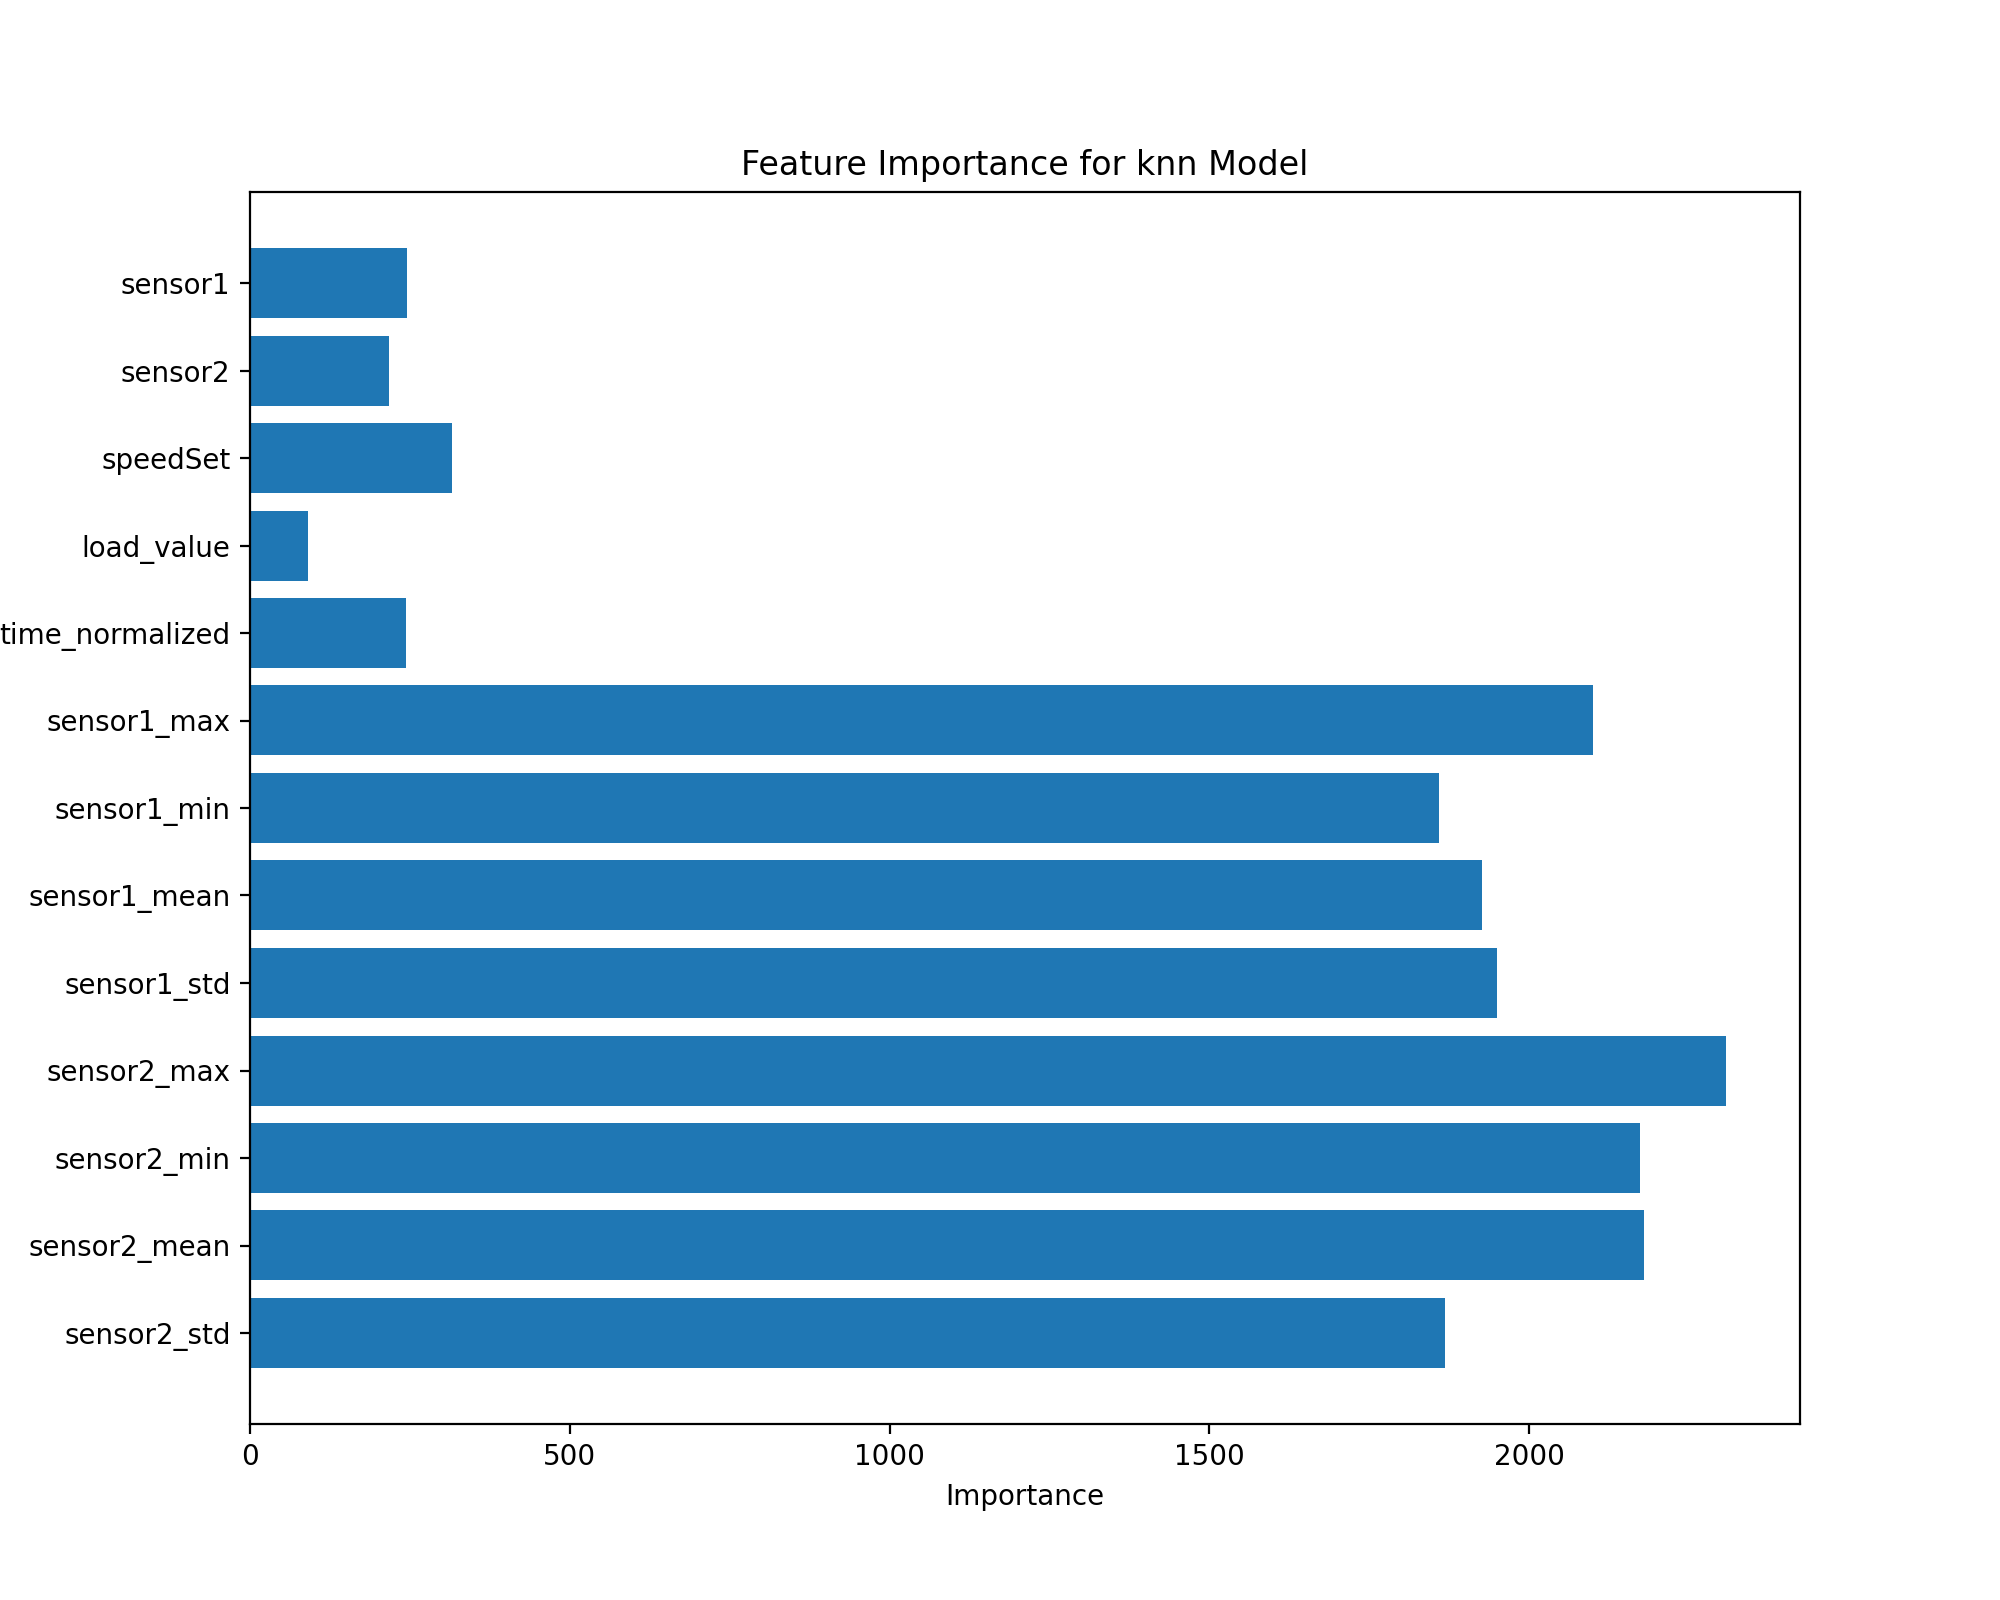

In [44]:
# Find the best models trained so far and print their names and validation accuracies and do feature importance the model
# with the highest validation accuracy
from sklearn.inspection import permutation_importance

models = {
    'lightGBM': accuracy_lgb,
    'xgboost': accuracy_xgb,
    'knn': accuracy_knn,
    'random_forest': accuracy_rf,
    'decision_tree': accuracy_dt,
    'svm': accuracy_svm,
    'mlp': accuracy_mlp,
}

# Find the best model
best_model_name = max(models, key=models.get)
best_model_accuracy = models[best_model_name]

print(f'Best model: {best_model_name}, Validation Accuracy: {best_model_accuracy}')

# Load the best model
best_model_path = f'models/{best_model_name}_{best_model_accuracy:.4f}.h5'
best_model = joblib.load(best_model_path)

# Feature importance
# If knn then we do it differently
if best_model_name == 'knn':
    # Perform permutation importance
    results = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    feature_importance = results.importances_mean
else:
    feature_imp = best_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(X_train_not_scaled.columns, feature_imp)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Feature Importance for {best_model_name} Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
plt.show()
plt.savefig(f'plots/feature_importance_{best_model_name}_{best_model_accuracy:.4f}.png')